In [3]:
#input is a strategy, like a repair sequence
#loop
#spend time, repair a node, assume repair is instant
#accumulate and compute resilience triangle
#re-check the functioning bus nodes if the repaired node is a bus node
#change the network parameters and re-run the model
#until sequence end

#repair sequence is some sequence of all broken links and bus
#use heuristic to find out the optimum solution


#this is a test comment
from power_util import delete_buses
from power_util import get_functional_nodes
from road_util import capacity_adjustment
from road_util import eval_tot_OD_travel_time
from interdependency import power_to_road
from run_tapb import run_tapb
from interdependency import repair_path_time
from plot_resilience import plot_triangles_seperate,plot_triangle_tot
import random
from deap import base, creator, tools, algorithms
import itertools
import os
from datetime import datetime
import shutil
import time

power_road_factor=0.5
broken_link_factor=0


def load_disrupted_scenatio(broken_buses,broken_links):
    unfunctional_nodes = delete_buses(broken_buses)
    capacity_adjustment(Org_network,Network1,broken_links,broken_link_factor) #delete link equal to change capacity into 0
    power_to_road(unfunctional_nodes,Network1,Network2,power_road_factor)   #This will edit the capacity of roadway link due to traffic light
    files=[]
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S-%f")[:23]
    os.makedirs(backup_dir, exist_ok=True)
    #backup_filepath=backup_dir+timestamp
    #shutil.copy2(Network2, backup_filepath)
    #files.append(timestamp)
    if os.path.exists('s.txt'):
        os.remove('s.txt')
    run_tapb(Network2,'tap-b/net/SiouxFalls_trips.txt') # 1. fix newest folder issue, #2 this is ugly now, change to parameters input later
    #shutil.copy2('flows.txt', backup_filepath+'flows.txt')
    if os.path.exists(Network2):
        os.remove(Network2)
    return files

def eval_road_resilience(broken_buses,broken_links):
    load_disrupted_scenatio(broken_buses,broken_links)
    #total travel time full Sioux Falls network:7,475,338
    return 7475338/eval_tot_OD_travel_time() 

def eval_power_resilience(broken_buses):
    # This represents "unsatisfied demand" 
    return 1-len(delete_buses(broken_buses))/33

def resilience_triangle(functionality,time):
    #求解若干个梯形面积之和
    #implement financial measures for different weights
    complement=0
    functionality_for_triangle=functionality+[1]
    for i in range(len(functionality)):
        complement+=(1-functionality_for_triangle[i]+1-functionality_for_triangle[i+1])*time[i]/2
    return complement

def resilience_evaluation(repair_seq):
    #This gives resilience "triangle"
    repair_seq=repair_seq.copy()
    resilience_road=[]
    resilience_power=[]
    time=[]
    net_file_names=[]
    previous_node=13
    while len(repair_seq)>0:
        broken_buses=[]
        broken_links=[]
        for item in repair_seq:
            if isinstance(item,int):
                broken_buses.append(item)
            else:
                broken_links.append(item)
        #take road output and read travel time, give number
        resilience_road.append(eval_road_resilience(broken_buses,broken_links))
        #take power output and give number
        resilience_power.append(eval_power_resilience(broken_buses))
        #repair and continue
        current_node,current_move_time=repair_path_time('s.txt',repair_seq[0],previous_node)
        time.append(current_move_time) 
        broken_buses=[bus for bus in broken_buses if bus!=repair_seq[0]]
        broken_links=[link for link in broken_links if link!=repair_seq[0]]
        #set up for next loop
        previous_node=current_node
        repair_seq.pop(0)
        #net_file_names.append(load_disrupted_scenatio(broken_buses,broken_links))
    full_resilience = resilience_triangle(resilience_road,time)+resilience_triangle(resilience_power,time)
    return full_resilience, resilience_road,resilience_power,time,net_file_names

###########################################################################################
#This is for the comparison between optimal considering interdependency and repair by type
##########################################################################################
def cxOrderedGrouped(ind1, ind2):
    """执行有序交叉 (Order Crossover, OX)，确保不产生重复元素且保持元组和整数的分组顺序。"""
    # Split individuals into tuple and int groups
    tuples_ind1 = [x for x in ind1 if isinstance(x, tuple)]
    ints_ind1 = [x for x in ind1 if isinstance(x, int)]
    tuples_ind2 = [x for x in ind2 if isinstance(x, tuple)]
    ints_ind2 = [x for x in ind2 if isinstance(x, int)]
    
    # Apply order crossover to tuples and ints separately
    def order_crossover(part1, part2):
        size = len(part1)
        a, b = sorted(random.sample(range(size), 2))
        
        child1 = [None] * size
        child2 = [None] * size
        
        # Copy the crossover slice from the first parent to the first child
        child1[a:b + 1] = part1[a:b + 1]
        child2[a:b + 1] = part2[a:b + 1]
        
        # Fill the remaining positions with the other parent's elements
        fill_pos1, fill_pos2 = (b + 1) % size, (b + 1) % size
        for i in range(size):
            pos = (b + 1 + i) % size
            if part2[pos] not in child1:
                child1[fill_pos1] = part2[pos]
                fill_pos1 = (fill_pos1 + 1) % size
            if part1[pos] not in child2:
                child2[fill_pos2] = part1[pos]
                fill_pos2 = (fill_pos2 + 1) % size
        
        return child1, child2
    
    # Perform order crossover for both tuples and integers
    child1_tuples, child2_tuples = order_crossover(tuples_ind1, tuples_ind2)
    child1_ints, child2_ints = order_crossover(ints_ind1, ints_ind2)
    
    # Combine tuples and ints back together
    child1 = child1_tuples + child1_ints
    child2 = child2_tuples + child2_ints
    
    return creator.Individual(child1), creator.Individual(child2)

def mutShuffleIndexesGrouped(individual, indpb):
    """执行突变操作，确保不产生重复元素且保持元组和整数的分组顺序。"""
    # Split individual into tuple and int groups
    tuples_part = [x for x in individual if isinstance(x, tuple)]
    ints_part = [x for x in individual if isinstance(x, int)]
    
    # Shuffle tuples and ints separately
    def shuffle_part(part):
        size = len(part)
        for i in range(size):
            if random.random() < indpb:
                swap_indx = random.randint(0, size - 1)
                part[i], part[swap_indx] = part[swap_indx], part[i]
        return part
    
    shuffled_tuples = shuffle_part(tuples_part)
    shuffled_ints = shuffle_part(ints_part)
    
    # Combine shuffled tuples and ints back together
    shuffled_individual = shuffled_tuples + shuffled_ints
    
    return creator.Individual(shuffled_individual),
###########################################################################################
##########################################################################################
##########################################################################################

def cxOrdered(ind1, ind2):
    """执行有序交叉 (Order Crossover, OX)，确保不产生重复元素"""
    size = len(ind1)
    a, b = sorted(random.sample(range(size), 2))
    
    child1 = [None]*size
    child2 = [None]*size
    
    # Copy the crossover slice from the first parent to the first child
    child1[a:b + 1] = ind1[a:b + 1]
    child2[a:b + 1] = ind2[a:b + 1]

    # Fill the remaining positions with the other parent's elements
    fill_pos1, fill_pos2 = (b + 1) % size, (b + 1) % size
    for i in range(size):
        pos = (b + 1 + i) % size
        if ind2[pos] not in child1:
            child1[fill_pos1] = ind2[pos]
            fill_pos1 = (fill_pos1 + 1) % size
        if ind1[pos] not in child2:
            child2[fill_pos2] = ind1[pos]
            fill_pos2 = (fill_pos2 + 1) % size

    return creator.Individual(child1), creator.Individual(child2)

def mutShuffleIndexes(individual, indpb):
    """执行突变操作，确保不产生重复元素"""
    size = len(individual)
    for i in range(size):
        if random.random() < indpb:
            swap_indx = random.randint(0, size - 1)
            individual[i], individual[swap_indx] = individual[swap_indx], individual[i]
    return creator.Individual(individual),

def heuristic_find_solution(initial_sequence,consider_interdependence):
    if len(initial_sequence) <= 1:
        raise ValueError("Initial sequence must contain more than one element.")

    if hasattr(creator, 'FitnessMin'):
        del creator.FitnessMin
    if hasattr(creator, 'Individual'):
        del creator.Individual
    # 创建最小化适应度类
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()

    # 定义个体的生成规则
    toolbox.register("individual", tools.initIterate, creator.Individual, lambda: random.sample(initial_sequence, len(initial_sequence)))

    # 定义种群的生成规则
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    # 定义适应度函数
    def eval_one_max(individual):
        single_run_time_0=datetime.now()
        fitness = resilience_evaluation(individual)[0]
        single_run_time=datetime.now()-single_run_time_0
        #print(f"Individual: {individual}, Fitness: {fitness}, Duration: {single_run_time}")  # 调试输出
        return (fitness,)

    toolbox.register("evaluate", eval_one_max)

    # 注册遗传算法的操作函数
    if consider_interdependence==True:
        toolbox.register("mate", cxOrdered)
        toolbox.register("mutate", mutShuffleIndexes, indpb=0.2)
    else:
        toolbox.register("mate", cxOrderedGrouped)
        toolbox.register("mutate", mutShuffleIndexesGrouped, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=7)

    # 初始化种群
    population = toolbox.population(n=100)
    print("Initial population:")  # 调试输出
    for ind in population[:5]:  # 只打印前5个个体
        print(ind)
    
    # 定义遗传算法的参数
    NGEN = 20  # 迭代次数
    CXPB = 0.5  # 交叉概率
    MUTPB = 0.2  # 突变概率
    
    # 记录日志
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", lambda x: sum([a[0] for a in x])/len(x))
    stats.register("min", min)
    stats.register("max", max)

    # 运行遗传算法
    algorithms.eaSimple(population, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN, 
                        stats=stats, verbose=True)
    
    # 找到最优个体
    best_ind = tools.selBest(population, 10)[0]
    with open("ans.txt", 'w') as file:
        file.writelines(str(best_ind))
    print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))
    return best_ind

run_start_time=datetime.now()
#To be replaced by relative references
Exp_folder='Experiment/'
Org_network=Exp_folder+"SiouxFalls_net.txt"
Network1 = Exp_folder + "SiouxFalls_net_link_delete.txt"
Network2 = Exp_folder+"SiouxFalls_net_use.txt"
backup_dir=Exp_folder+"Backup_nets/"
result_folder=Exp_folder+ datetime.now().strftime("%Y-%m-%d_%H-%M-%S")+'/'
os.makedirs(result_folder, exist_ok=True)
#To be replaced by random generated ones
#broken_bus_init=[11,17]
#broken_links_init=[(8,9),(9,8),(24,21),(21,24)]
sequence=[11,17,15,(9,10),28,32,(11,14)]
#print(resilience_evaluation([9,8,6,1,6,3,3]))

"""
#####################debug session###################################
myind=[(9, 10), 28, 11, 17, 15, 32, (11, 14)]
result_opt, road_opt, power_opt, time_opt,net_files=resilience_evaluation(myind)
plot_triangles_seperate(road_opt,power_opt,time_opt,result_folder+'test')
plot_triangle_tot(road_opt,power_opt,time_opt,result_folder+'test')
with open(result_folder+'output_test.txt', 'w') as f:
    print("This is optimal considering interdependence", file=f)
    print(myind, file=f)
    print("total complement resilience(not average): ", result_opt, file=f)
    print("road resilience: ", road_opt, file=f)
    print("power resilience: ", power_opt, file=f)
    print("time steps: ", time_opt, file=f)
    print("net files: ", net_files, file=f)
    print()
exit()
"""

def run_model(sequence,bool_stream,result_folder,message,Scenario,plot_control):
    if os.path.exists('bus_location.json'):
        os.remove('bus_location.json')
    if os.path.exists('bus_to_link.json'):
        os.remove('bus_to_link.json')   
    if Scenario[-5:]=='SENS4':
        shutil.copy2('SENS4_bus_to_link.json', 'bus_to_link.json')
    else:
        shutil.copy2('original_bus_to_link.json', 'bus_to_link.json')
    if Scenario[-5:]=='SENS2':
        shutil.copy2('SENS4_bus_location.json', 'bus_location.json')
    else:
        shutil.copy2('original_bus_location.json', 'bus_location.json')
    run_start_time=datetime.now()
    if Scenario[:4]=='eval':
        myind=sequence
        print("eval")
    else:
        myind=heuristic_find_solution(sequence,bool_stream)
    #myind=sequence #this is used for debug

    run_end_time=datetime.now()
    duration=run_end_time - run_start_time
    #seperate final back up nets with others

    result_opt, road_opt, power_opt, time_opt,net_files=resilience_evaluation(myind)
    if plot_control==True:
        #for the best solution, draw the resilience triangle
        plot_triangles_seperate(road_opt,power_opt,time_opt,result_folder+Scenario)
        plot_triangle_tot(road_opt,power_opt,time_opt,result_folder+Scenario)
    with open(result_folder+'output.txt', 'a') as f:
        print(message, file=f)
        print(myind, file=f)
        print("run duration: " + str(duration), file=f)
        print("total complement resilience(not average): ", result_opt, file=f)
        print("road resilience: ", road_opt, file=f)
        print("power resilience: ", power_opt, file=f)
        print("time steps: ", time_opt, file=f)
        print("-------------------------------------------------------------------------",file=f)
        print()

    return myind,road_opt,power_opt,time_opt

The following is the random model

eval


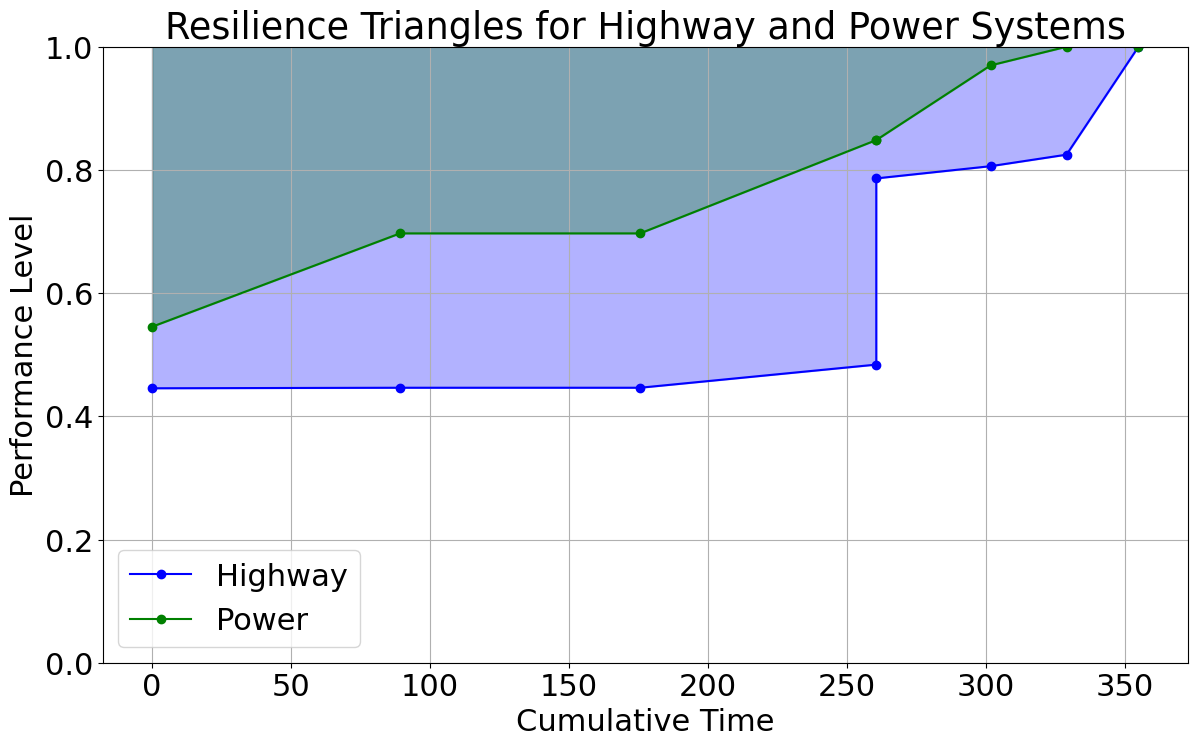

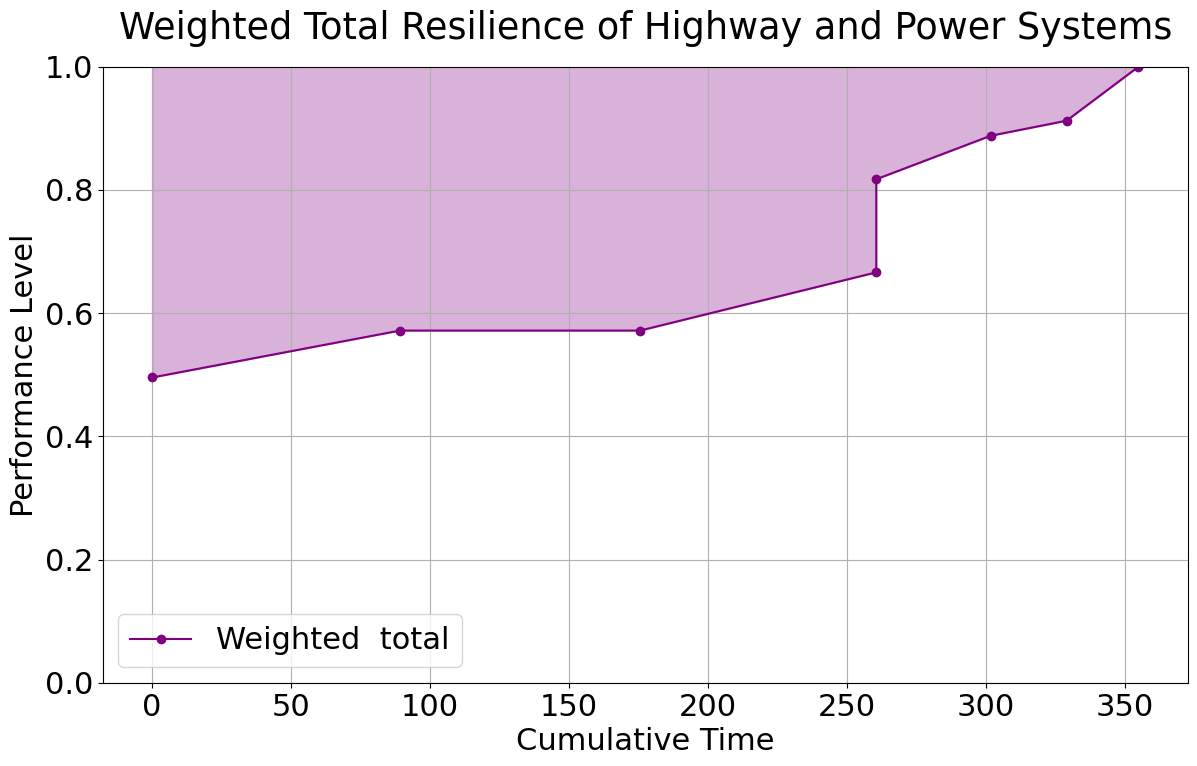

In [71]:
seq_default_random,roadres_default_random,powerres_default_random,time_default_random=run_model(sequence,True,result_folder,"This is random",'evalrand',True)   #consider default sequence as random

eval


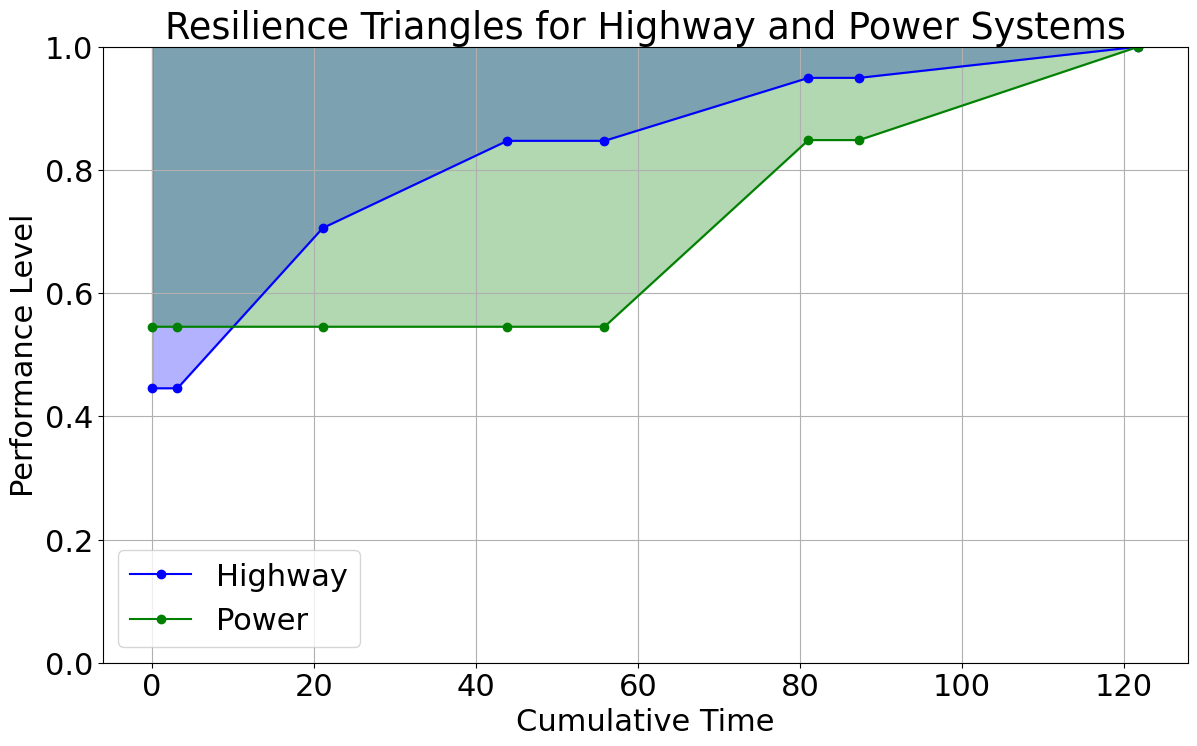

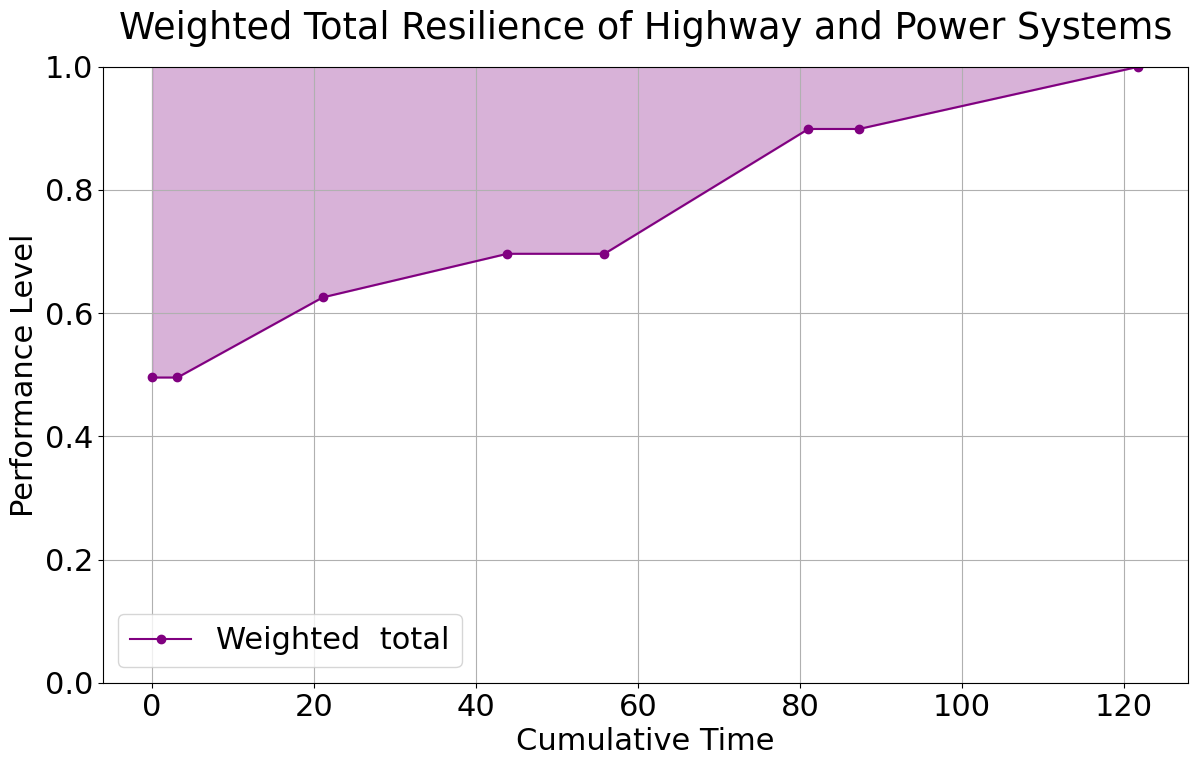

([17, (9, 10), (11, 14), 15, 11, 32, 28],
 [0.44553396095539116,
  0.44553396095539116,
  0.7056831520794121,
  0.847252092630669,
  0.847252092630669,
  0.949464697637762,
  0.949464697637762],
 [0.5454545454545454,
  0.5454545454545454,
  0.5454545454545454,
  0.5454545454545454,
  0.5454545454545454,
  0.8484848484848485,
  0.8484848484848485],
 [3.133136, 17.931908, 22.778905, 11.996568, 25.178403, 6.258539, 34.487867])

In [72]:
opt_cheat=[17, (9, 10), (11, 14), 15, 11, 32, 28]
run_model(opt_cheat,True,result_folder,"This is cheat optimal considering interdependence",'eval',True)

The following is the default model

Initial population:
[15, 28, (11, 14), 32, 11, (9, 10), 17]
[(11, 14), 17, 32, (9, 10), 11, 15, 28]
[(11, 14), 28, 11, (9, 10), 32, 17, 15]
[11, 15, 17, (9, 10), (11, 14), 28, 32]
[17, (11, 14), 11, 32, 15, 28, (9, 10)]
gen	nevals	avg    	min                	max                 
0  	100   	162.084	(79.6632440103815,)	(331.8975194178975,)
1  	63    	127.341	(67.51049885834351,)	(300.4767881482951,)
2  	70    	100.581	(64.55106063475117,)	(292.40190029232076,)
3  	66    	98.941 	(64.55106063475117,)	(268.94839259696954,)
4  	57    	79.9108	(64.55106063475117,)	(238.53940959152686,)
5  	55    	86.5007	(64.55106063475117,)	(228.22672847542992,)
6  	56    	77.8619	(64.4034448928816,) 	(261.55168322875414,)
7  	61    	76.2589	(64.4034448928816,) 	(193.59598253976455,)
8  	65    	76.061 	(61.71663675321366,)	(193.59598253976455,)
9  	55    	79.6336	(60.3954942702769,) 	(265.5453834733188,) 
10 	57    	71.4026	(60.19352980543566,)	(169.76571549729584,)
11 	53    	71.7997	(60.19352980543566,)	(

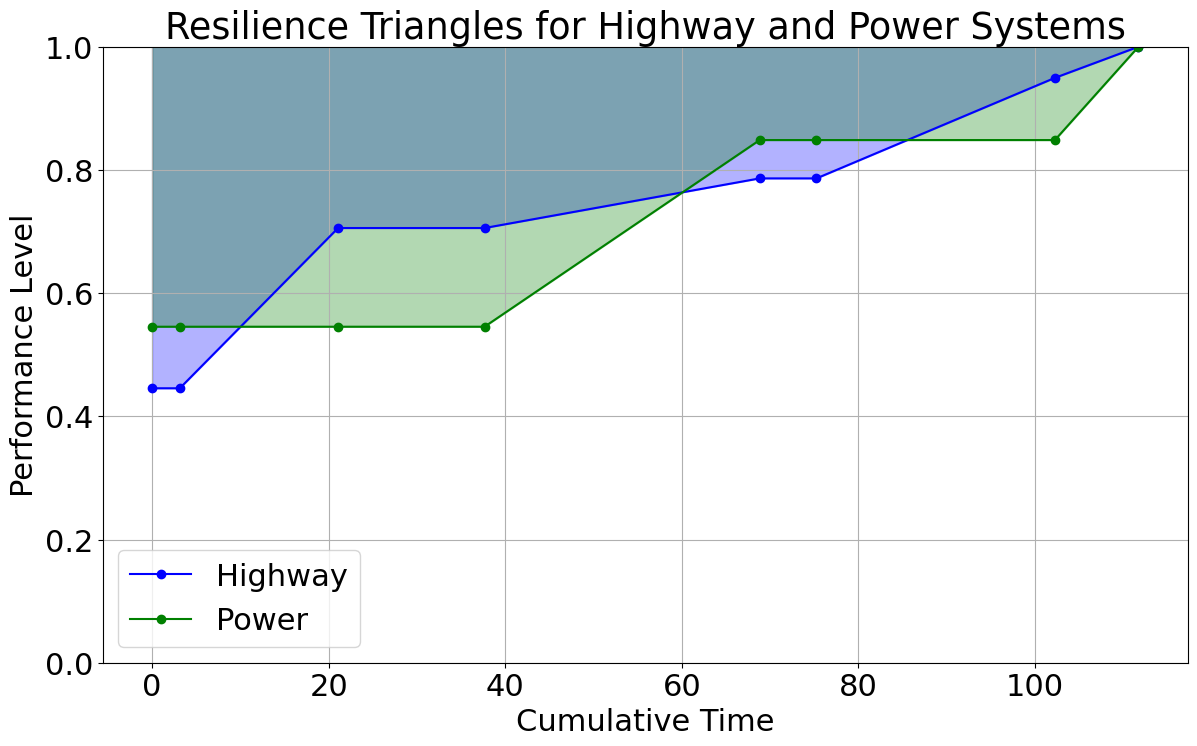

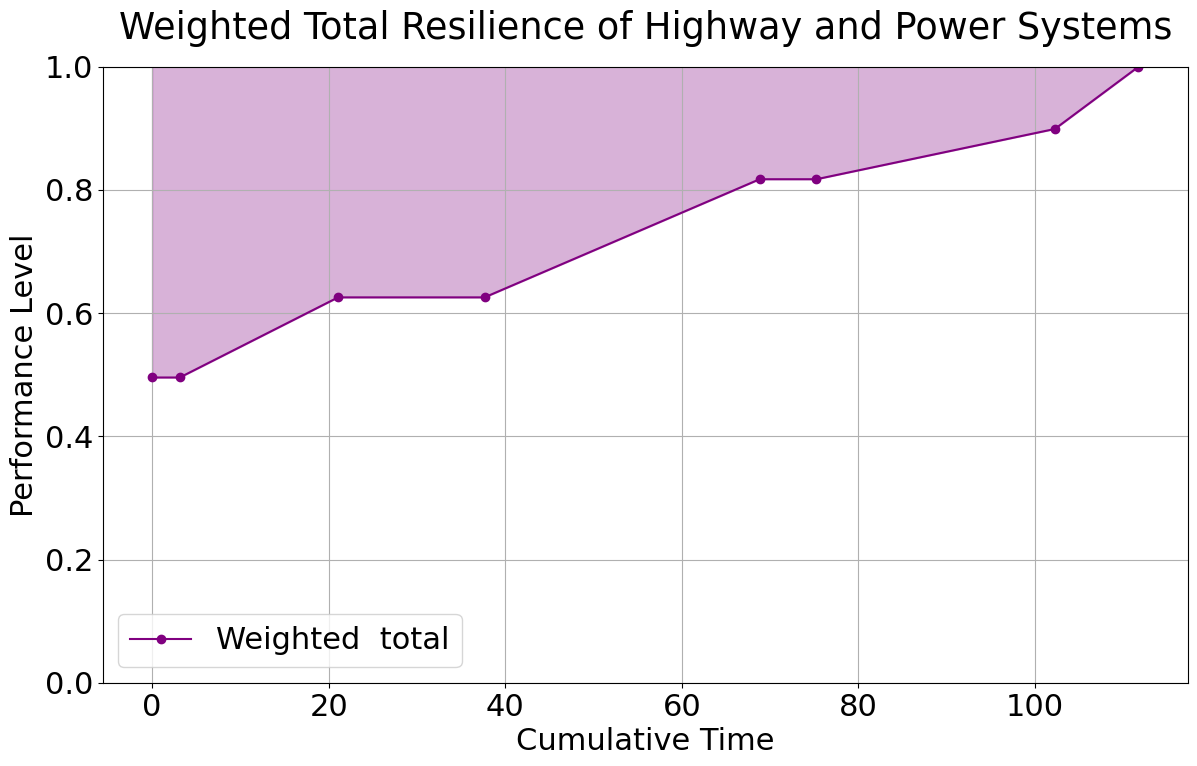

In [73]:
seq_default_opt,roadres_default_opt,powerres_default_opt,time_default_opt=run_model(sequence,True,result_folder,"This is optimal considering interdependence",'opt',True)

In [74]:
powers_only=[11,17,15,28,32]
roads_only=[(9,10),(11,14)]
power_ans=run_model(powers_only,True,result_folder,"This is optimal Power only",'optPower',False)[0]
roads_ans=run_model(roads_only,True,result_folder,"This is optimal Road only",'optRoad',False)[0]
road_priority=roads_ans+power_ans
power_priority=power_ans+roads_ans

Initial population:
[28, 15, 17, 32, 11]
[32, 17, 11, 28, 15]
[32, 17, 15, 28, 11]
[15, 28, 11, 32, 17]
[32, 28, 15, 17, 11]
gen	nevals	avg    	min                 	max                  
0  	100   	58.5513	(34.17123621882265,)	(101.39061354682711,)
1  	73    	43.1556	(34.17123621882265,)	(94.41353727166454,) 
2  	63    	36.9653	(33.749758573973324,)	(60.41090181640891,) 
3  	78    	35.0148	(33.749758573973324,)	(63.8262470765265,)  
4  	58    	36.6522	(33.749758573973324,)	(92.74468729606994,) 
5  	60    	36.0691	(33.749758573973324,)	(80.16222896900555,) 
6  	61    	34.7525	(33.749758573973324,)	(53.901236474408904,)
7  	63    	35.1582	(33.749758573973324,)	(55.5669386256481,)  
8  	59    	35.4741	(33.749758573973324,)	(69.7177347890223,)  
9  	47    	33.9549	(33.749758573973324,)	(46.81923428659934,) 
10 	71    	35.2423	(33.749758573973324,)	(63.8262470765265,)  
11 	70    	34.7697	(33.749758573973324,)	(69.52427069511502,) 
12 	46    	34.4814	(33.749758573973324,)	(50.8170160356698,

Road Priority

eval


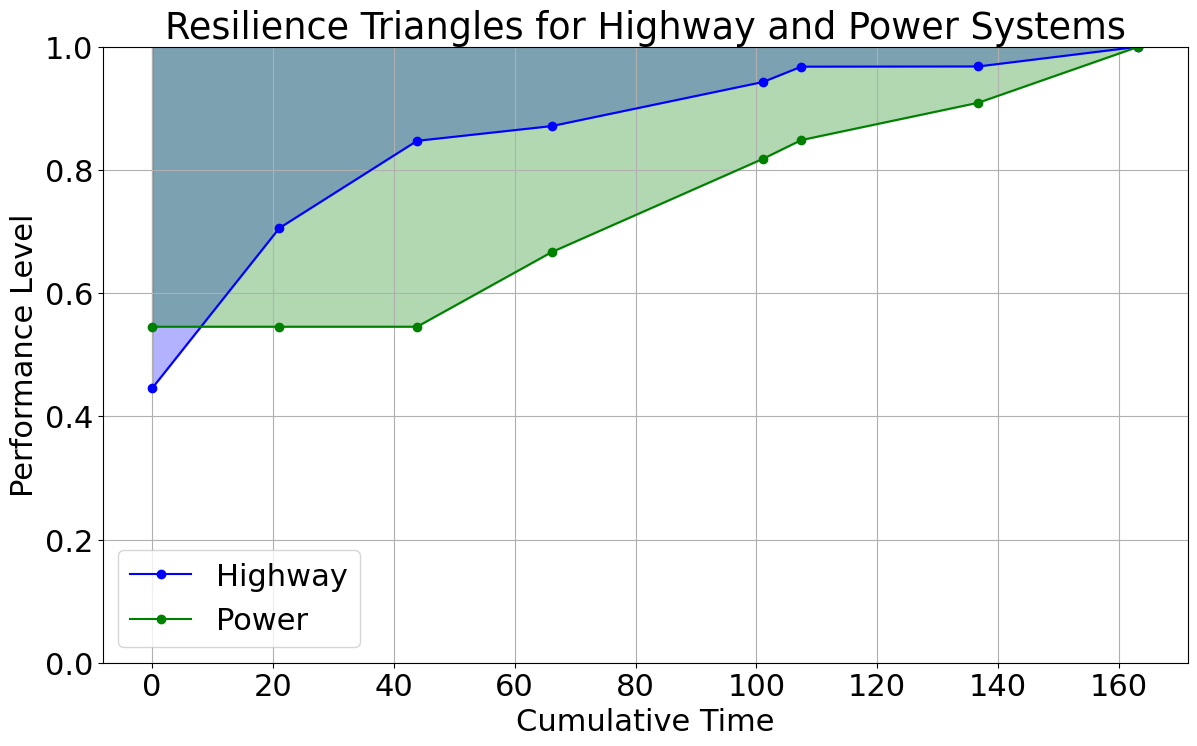

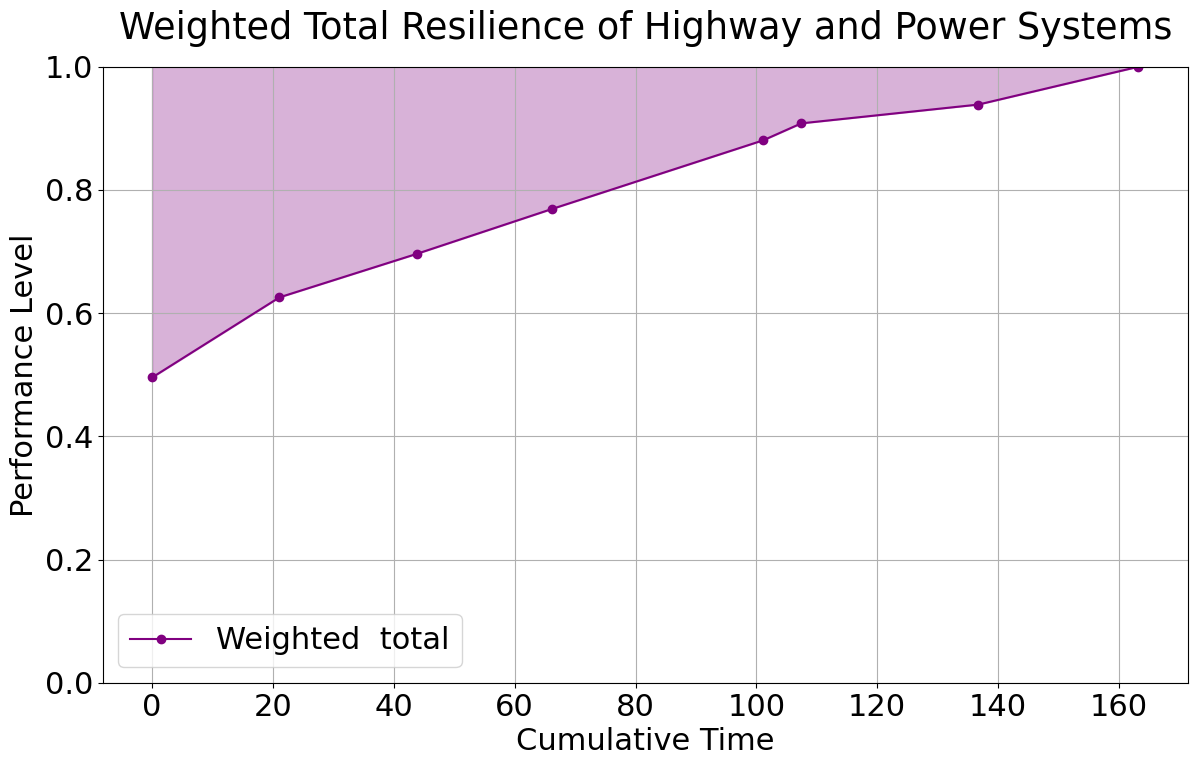

In [75]:
seq_default_roadpri,roadres_default_roadpri,powerres_default_roadpri,time_default_roadpri=run_model(road_priority,True,result_folder,"This is Road priority",'evalRoadPriority',True)

Power Priority

eval


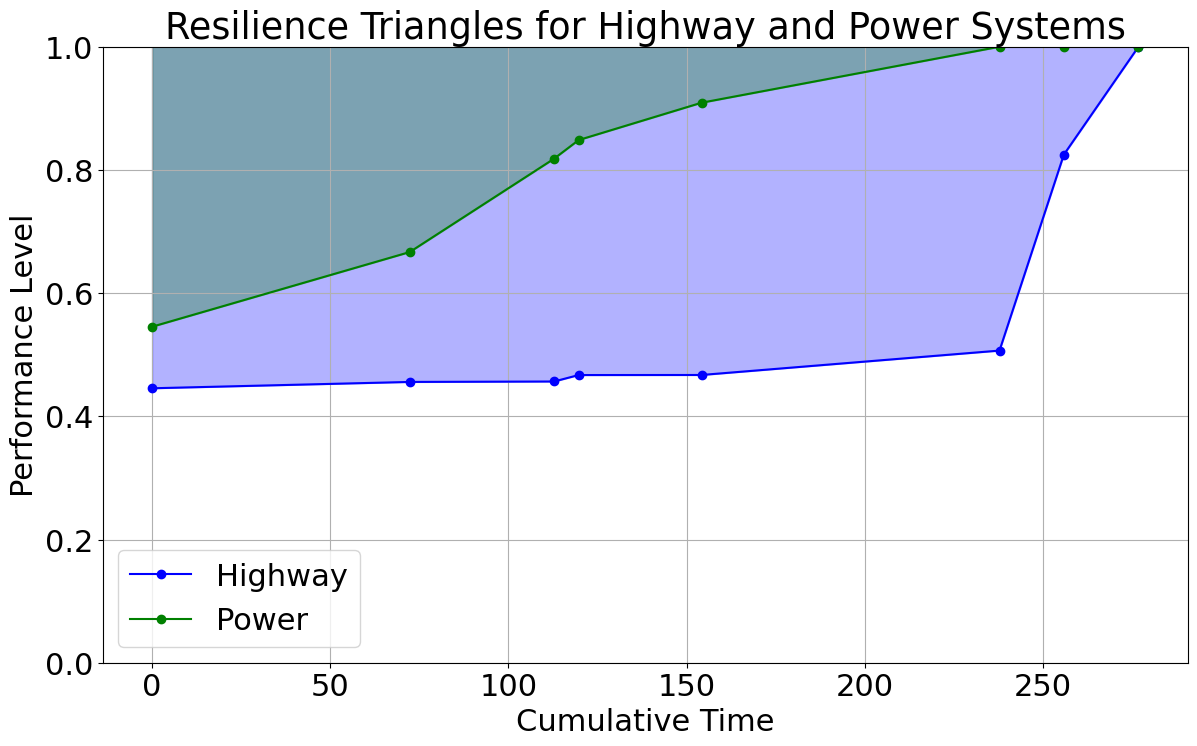

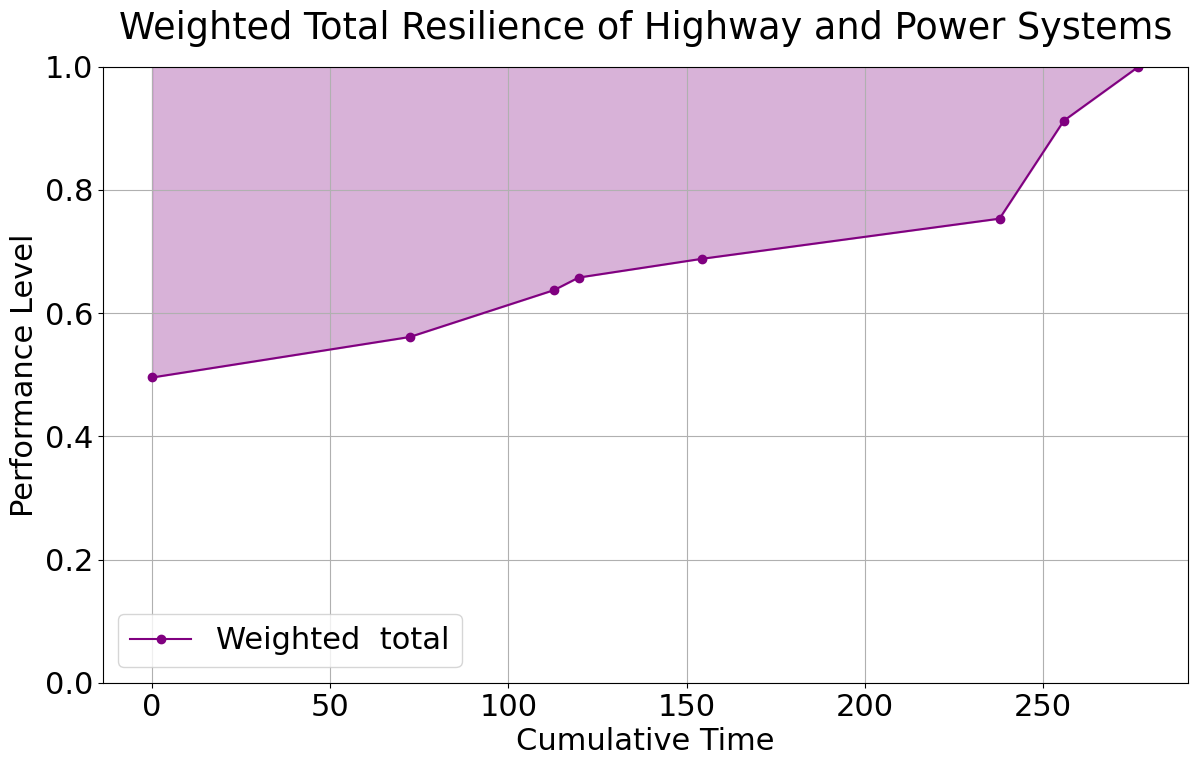

In [76]:
seq_default_powerpri,roadres_default_powerpri,powerres_default_powerpri,time_default_powerpri=run_model(power_priority,True,result_folder,"This is Power priority",'evalPowerPriority',True)

Sensitivity design
Sensitivity #1: 
increase the number of broken links/nets

eval


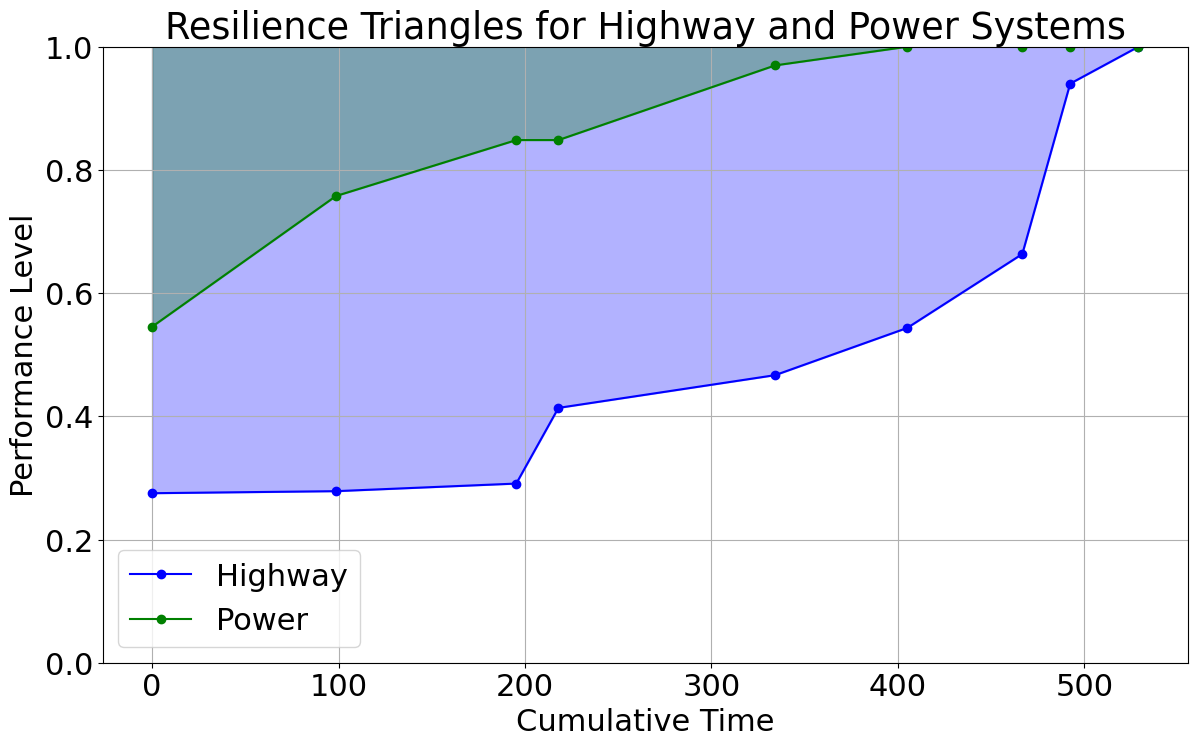

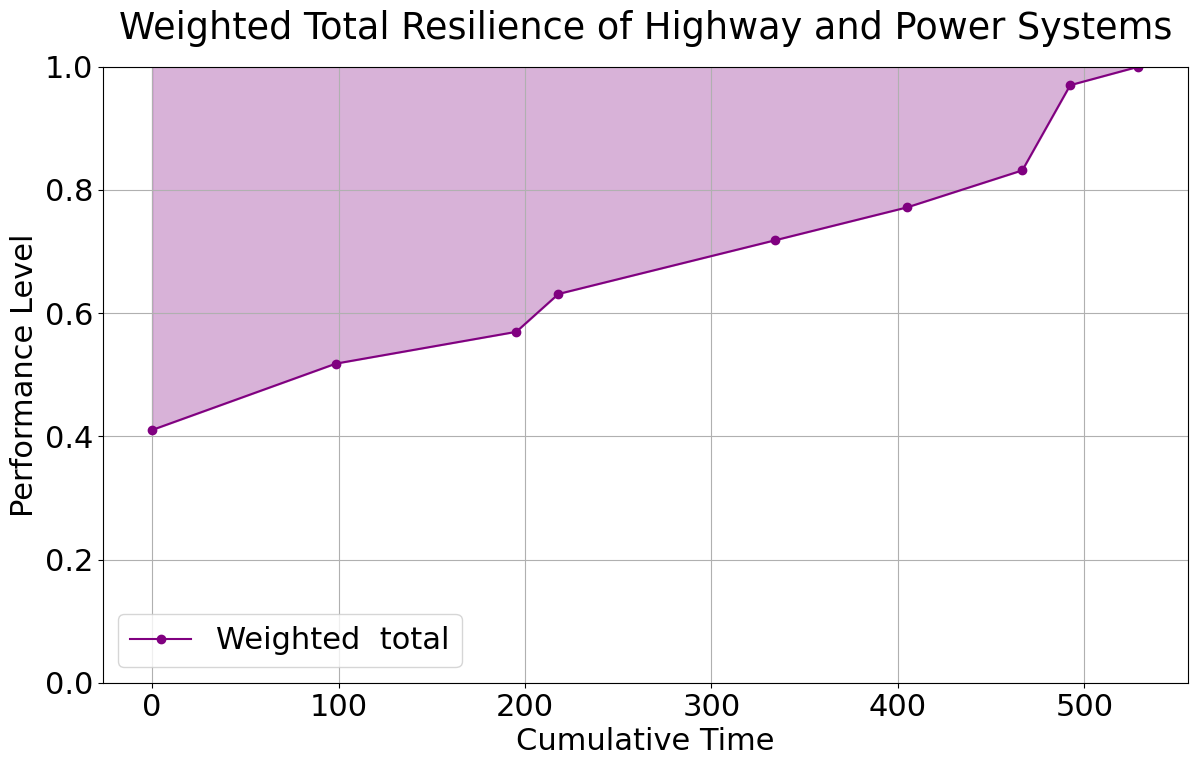

([11, 17, (9, 10), 28, 32, (11, 14), (15, 22), (2, 6)],
 [0.2751974005330034,
  0.2785080342576047,
  0.29084029029968783,
  0.4136860242179209,
  0.4668381999946067,
  0.5435080699192547,
  0.6635002251910879,
  0.9400822150101154],
 [0.5454545454545454,
  0.7575757575757576,
  0.8484848484848485,
  0.8484848484848485,
  0.9696969696969697,
  1.0,
  1.0,
  1.0],
 [98.56688400000002,
  96.754042,
  22.600723,
  116.221557,
  70.87117,
  61.723168,
  25.681462000000003,
  36.616465000000005])

In [77]:
SENS1_sequence=[11,17,(9,10),28,32,(11,14),(15,22),(2,6)]
run_model(SENS1_sequence,True,result_folder,"This is random of SENSITIVITY increase breaks",'evalrandSENS1',True)

Initial population:
[11, 17, 28, 32, (9, 10), (11, 14), (2, 6), (15, 22)]
[32, 28, (9, 10), 11, (11, 14), (15, 22), 17, (2, 6)]
[32, (11, 14), 28, 17, 11, (2, 6), (15, 22), (9, 10)]
[32, (15, 22), (2, 6), 11, (11, 14), 17, 28, (9, 10)]
[28, 32, 17, (9, 10), 11, (15, 22), (11, 14), (2, 6)]
gen	nevals	avg    	min                  	max                  
0  	100   	294.612	(123.60019895199206,)	(488.43213575252094,)
1  	57    	217.939	(123.60019895199206,)	(453.30577624927344,)
2  	55    	178.967	(113.40772485824354,)	(513.3187566643232,) 
3  	63    	177.114	(100.14203895851722,)	(446.5997473609697,) 
4  	62    	146.962	(96.55486083935276,) 	(407.86772066401886,)
5  	62    	132.062	(94.79381589681597,) 	(321.30680372087005,)
6  	60    	120.085	(94.98844439547601,) 	(356.7622622919205,) 
7  	57    	123.662	(94.98844439547601,) 	(426.8318587586454,) 
8  	58    	122.868	(94.98844439547601,) 	(317.7147711075256,) 
9  	67    	118.629	(94.98844439547601,) 	(352.27687053908204,)
10 	56    	109.13

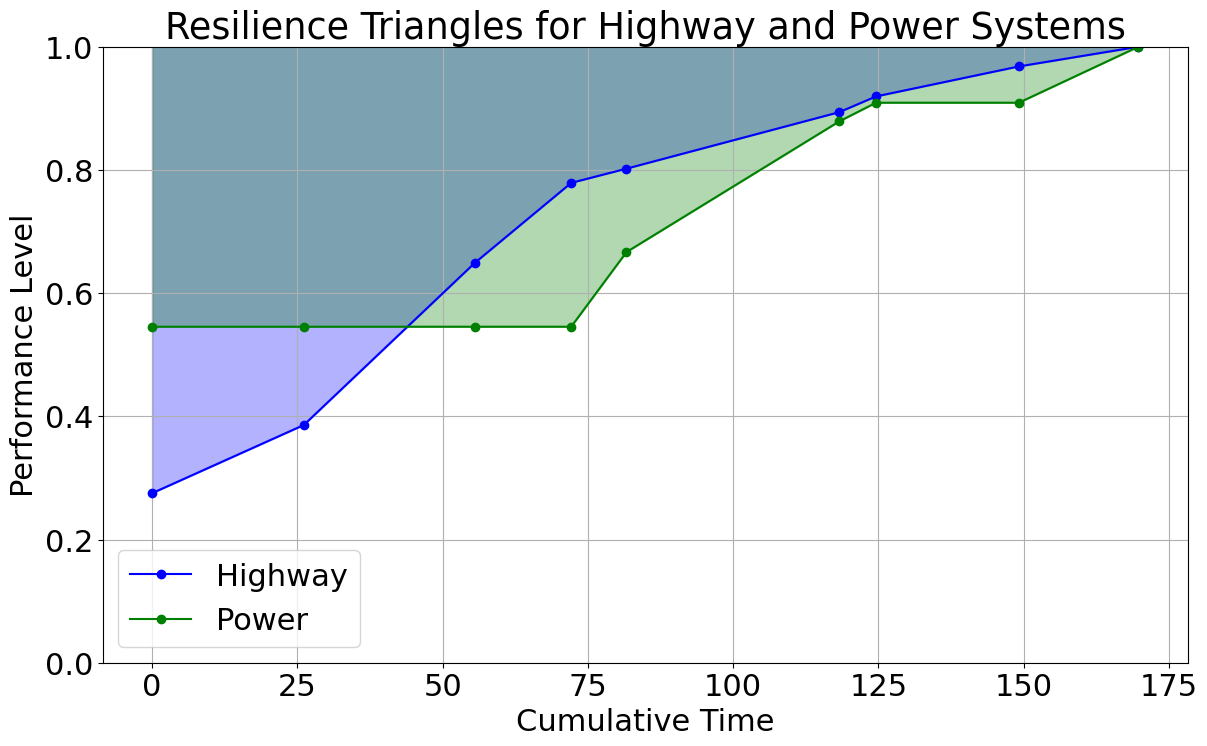

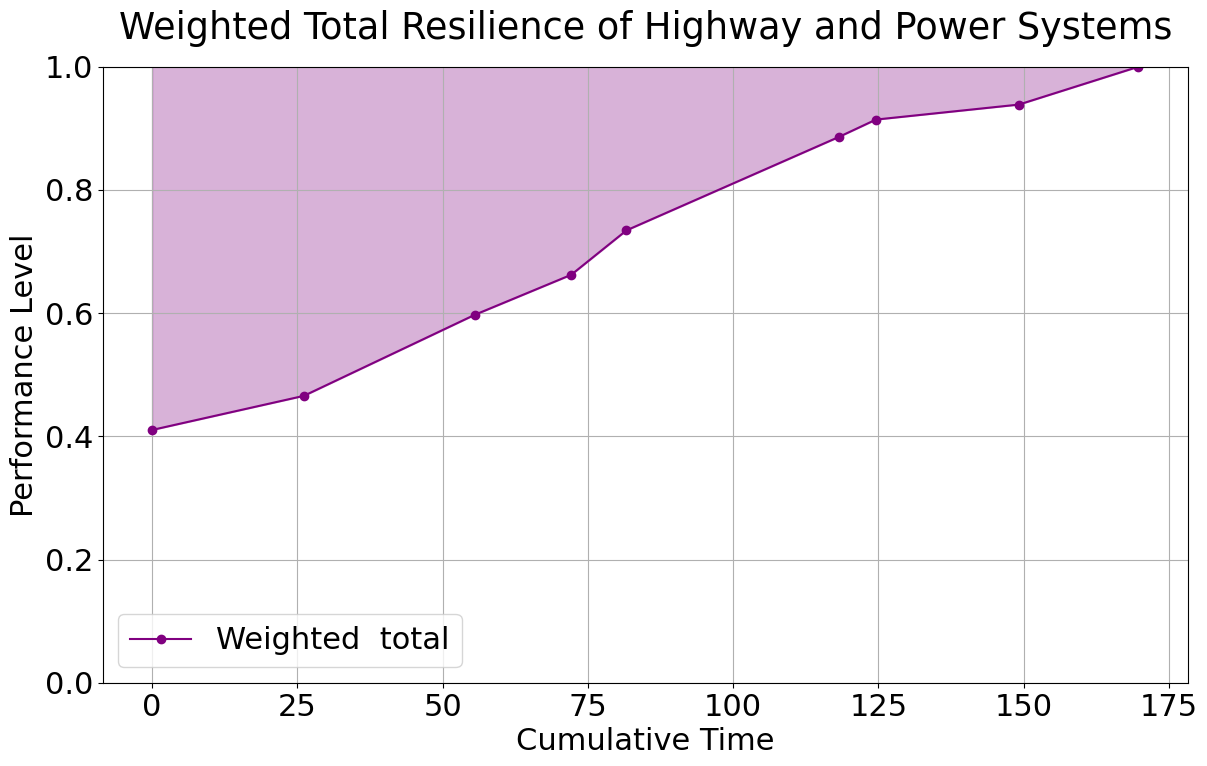

In [78]:
seq_SENS1_opt,roadres_SENS1_opt,powerres_SENS1_opt,time_SENS1_opt=run_model(SENS1_sequence,True,result_folder,"This is SENSITIVITY increase breaks",'SENS1',True)

In [79]:
powers_only_sens1=[11,17,28,32]
roads_only_sens1=[(9,10),(11,14),(15,22),(2,6)]
power_ans_sens1=run_model(powers_only_sens1,True,result_folder,"This is optimal Power only SENS1",'optPowerSENS1',False)[0]
roads_ans_sens1=run_model(roads_only_sens1,True,result_folder,"This is optimal Road only SENS1",'optRoadSENS1',False)[0]
power_priority_sens1=power_ans_sens1+roads_ans_sens1
road_priority_sens1=roads_ans_sens1+power_ans_sens1

Initial population:
[28, 11, 17, 32]
[32, 17, 11, 28]
[28, 32, 17, 11]
[17, 32, 11, 28]
[28, 32, 17, 11]
gen	nevals	avg    	min               	max                 
0  	100   	43.4397	(26.079454345436,)	(82.53552808578978,)
1  	72    	30.8756	(26.079454345436,)	(54.328716929846685,)
2  	61    	27.7101	(26.079454345436,)	(55.64318546404142,) 
3  	72    	27.3588	(26.079454345436,)	(48.94304258429474,) 
4  	67    	26.7291	(26.079454345436,)	(45.29858025326566,) 
5  	64    	28.5101	(26.079454345436,)	(82.53552808578978,) 
6  	63    	27.1383	(26.079454345436,)	(45.29858025326566,) 
7  	61    	27.6239	(26.079454345436,)	(82.53552808578978,) 
8  	65    	27.75  	(26.079454345436,)	(82.53552808578978,) 
9  	59    	26.9329	(26.079454345436,)	(55.64318546404142,) 
10 	59    	27.6169	(26.079454345436,)	(82.53552808578978,) 
11 	67    	26.8157	(26.079454345436,)	(55.64318546404142,) 
12 	67    	27.106 	(26.079454345436,)	(55.64318546404142,) 
13 	61    	27.0419	(26.079454345436,)	(55.64318546404142,

eval


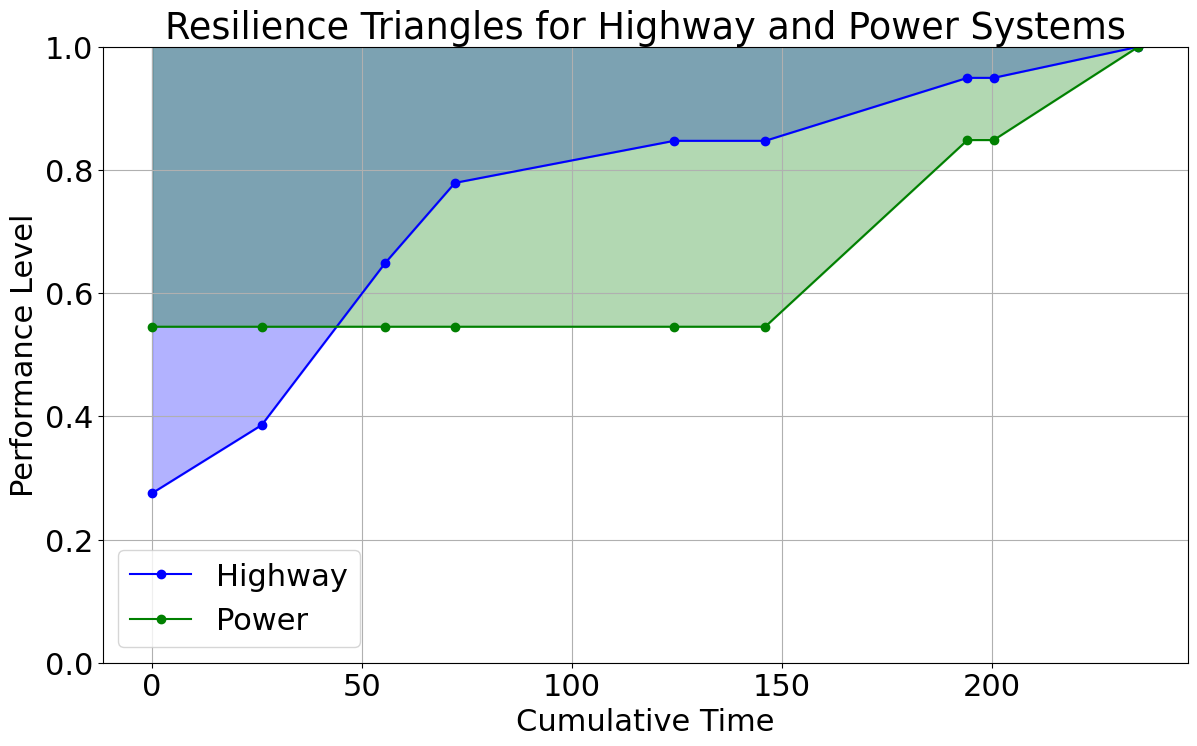

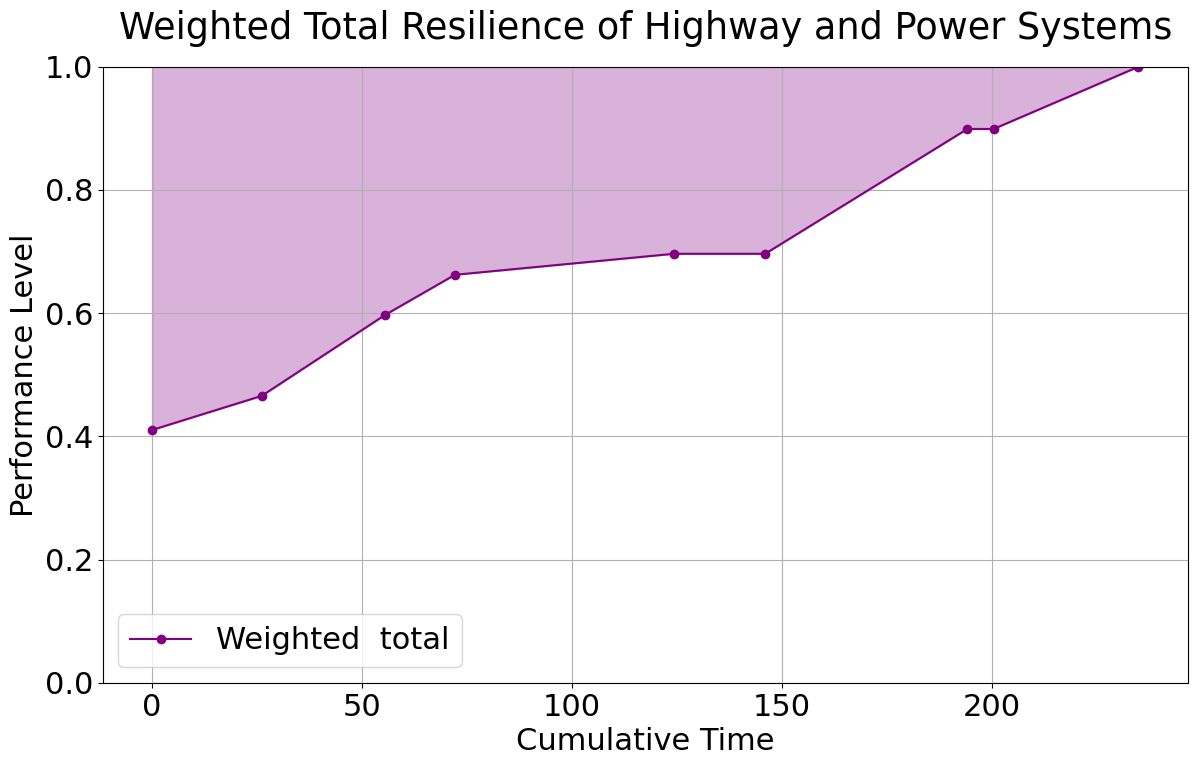

In [80]:
seq_SENS1_roadpri,roadres_SENS1_roadpri,powerres_SENS1_roadpri,time_SENS1_roadpri=run_model(road_priority_sens1,True,result_folder,"This is Road priority SENS1",'evalRoadPrioritySENS1',True)

eval


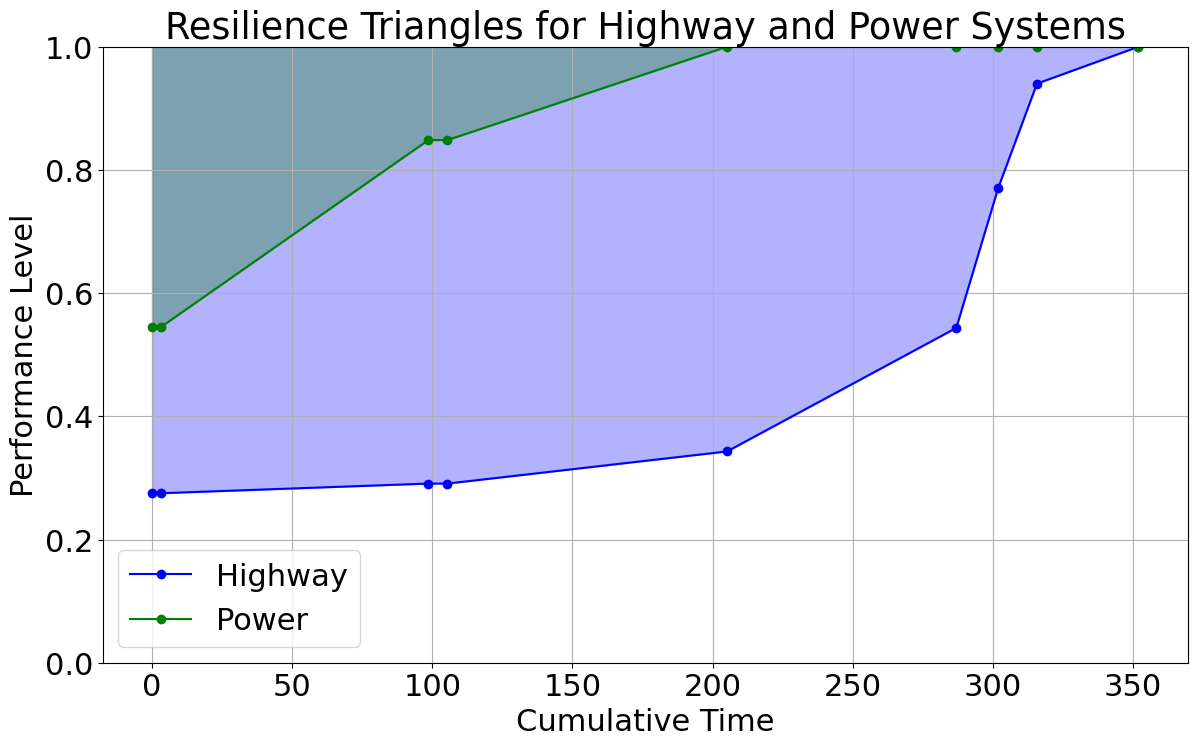

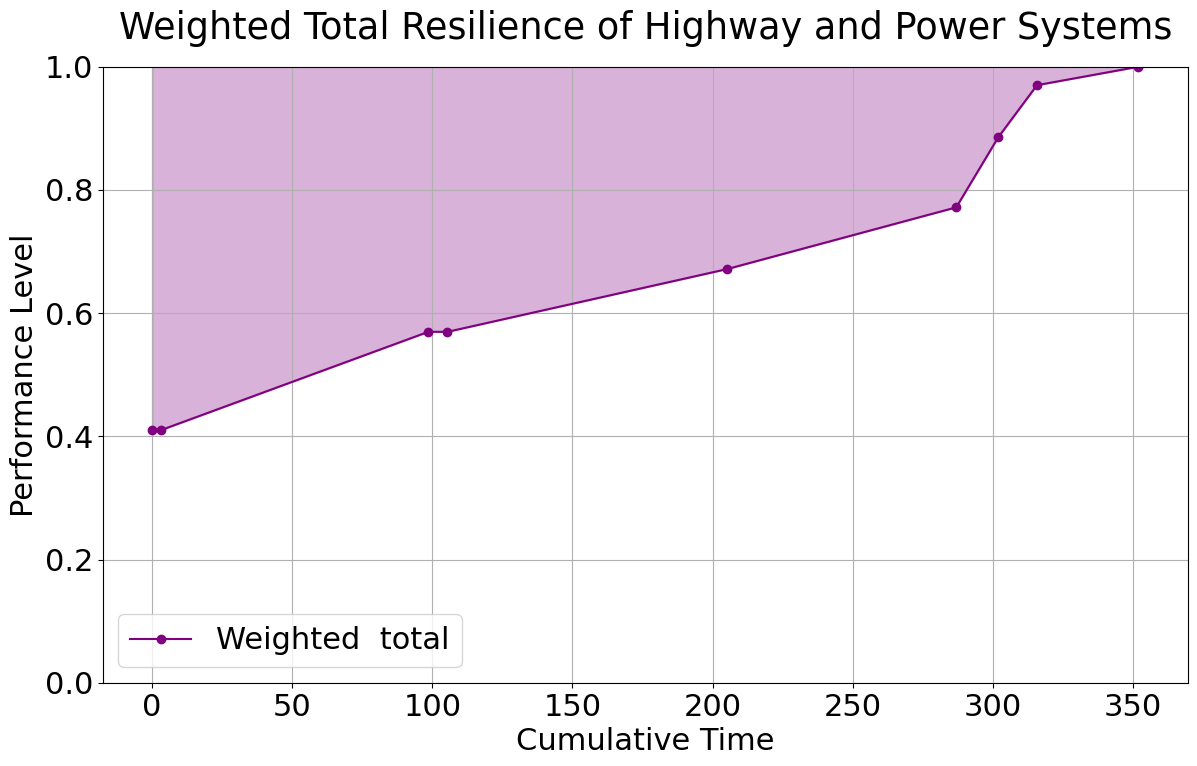

In [81]:
seq_SENS1_powerpri,roadres_SENS1_powerpri,powerres_SENS1_powerpri,time_SENS1_powerpri=run_model(power_priority_sens1,True,result_folder,"This is Power priority SENS1",'evalPowerPrioritySENS1',True)

Sensitivity#2:
move the connection points around

Initial population:
[(11, 14), (9, 10), 32, 17, 11, 28, 15]
[32, (9, 10), 15, (11, 14), 28, 11, 17]
[32, (9, 10), (11, 14), 11, 17, 28, 15]
[17, 11, 32, (9, 10), 28, (11, 14), 15]
[32, (11, 14), 11, 28, 15, (9, 10), 17]
gen	nevals	avg    	min                 	max                  
0  	100   	166.234	(59.33270111554958,)	(404.10383935657455,)
1  	51    	106.131	(51.573400347708045,)	(267.4741734660838,) 
2  	59    	76.3963	(51.573400347708045,)	(297.8003332124415,) 
3  	58    	68.9853	(51.573400347708045,)	(261.2746103469691,) 
4  	59    	58.4554	(51.573400347708045,)	(157.81465484585704,)
5  	60    	62.1763	(51.573400347708045,)	(251.20813431336296,)
6  	43    	59.4329	(51.573400347708045,)	(186.96780381324828,)
7  	54    	60.5113	(50.23489863355882,) 	(316.9213450585544,) 
8  	68    	58.591 	(50.23489863355882,) 	(177.0824345424524,) 
9  	60    	58.8462	(50.23489863355882,) 	(173.01039402943445,)
10 	55    	58.484 	(50.23489863355882,) 	(182.04000098385495,)
11 	57    	59.687 	(50.234

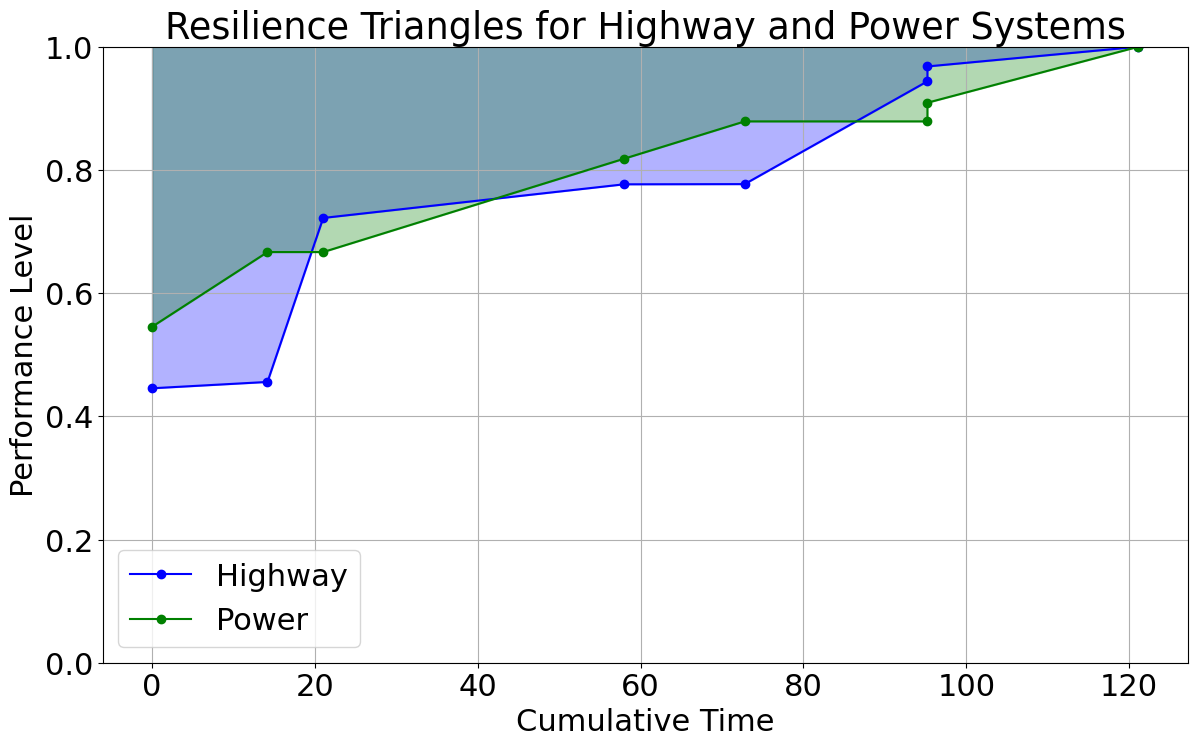

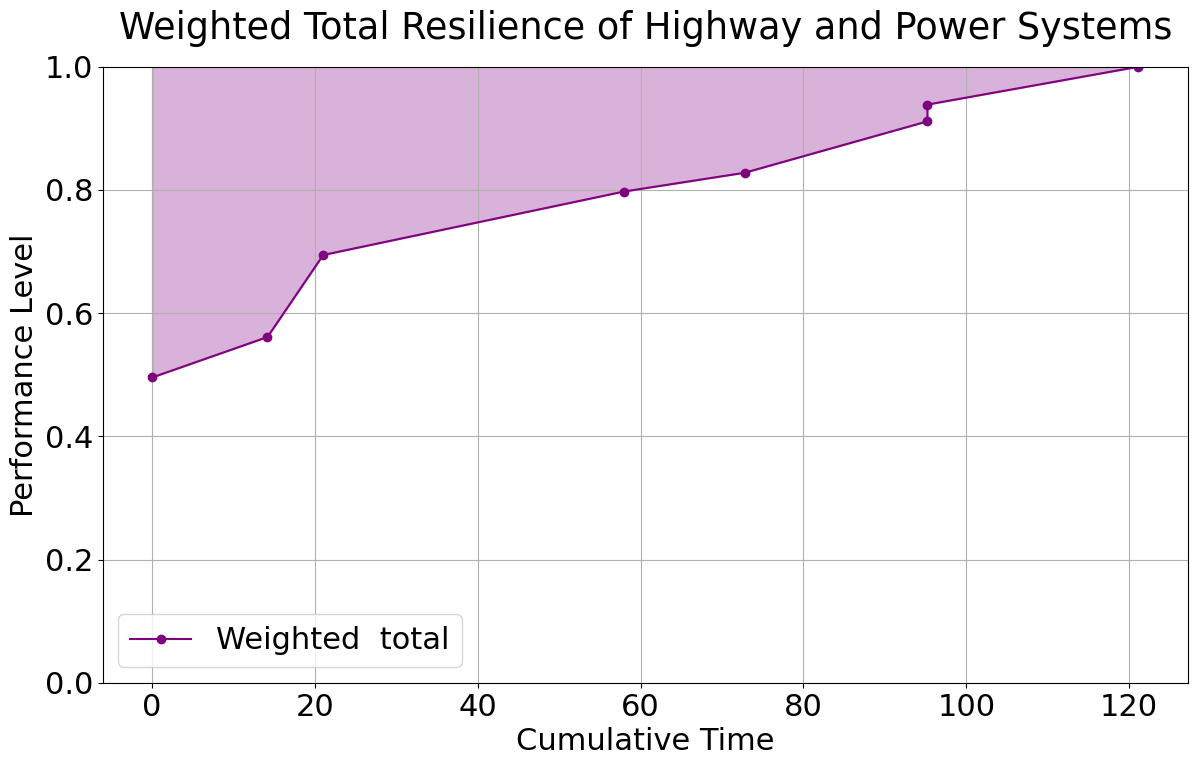

In [82]:
seq_SENS2_opt,roadres_SENS2_opt,powerres_SENS2_opt,time_SENS2_opt=run_model(sequence,True,result_folder,"This is SENSITIVITY #2, move connections around",'SENS2',True)

In [83]:
powers_only=[11,17,15,28,32]
roads_only=[(9,10),(11,14)]
power_ans=run_model(powers_only,True,result_folder,"This is optimal Power only SENS2",'optPowerSENS2',False)[0]
roads_ans=run_model(roads_only,True,result_folder,"This is optimal Road only SENS2",'optRoadSENS2',False)[0]

Initial population:
[11, 32, 28, 17, 15]
[11, 17, 32, 15, 28]
[15, 11, 17, 28, 32]
[17, 11, 28, 15, 32]
[32, 11, 28, 15, 17]
gen	nevals	avg    	min                 	max                 
0  	100   	51.6123	(24.40383206779259,)	(94.92451895320528,)
1  	60    	37.0364	(24.40383206779259,)	(78.3178946245351,) 
2  	60    	29.2564	(24.40383206779259,)	(62.134842807948644,)
3  	59    	26.9041	(24.40383206779259,)	(62.054052135179376,)
4  	66    	27.9337	(24.40383206779259,)	(68.29626299430745,) 
5  	55    	25.9966	(24.40383206779259,)	(60.542252053392005,)
6  	66    	25.8223	(24.40383206779259,)	(50.050280955537154,)
7  	65    	25.8621	(24.40383206779259,)	(60.542252053392005,)
8  	59    	27.0637	(24.40383206779259,)	(84.35787385445806,) 
9  	70    	27.9461	(24.40383206779259,)	(62.65877862268054,) 
10 	59    	26.567 	(24.40383206779259,)	(62.25652890800497,) 
11 	71    	26.1352	(24.40383206779259,)	(61.70091077027604,) 
12 	61    	26.7628	(24.40383206779259,)	(60.542252053392005,)
13 	57    

eval


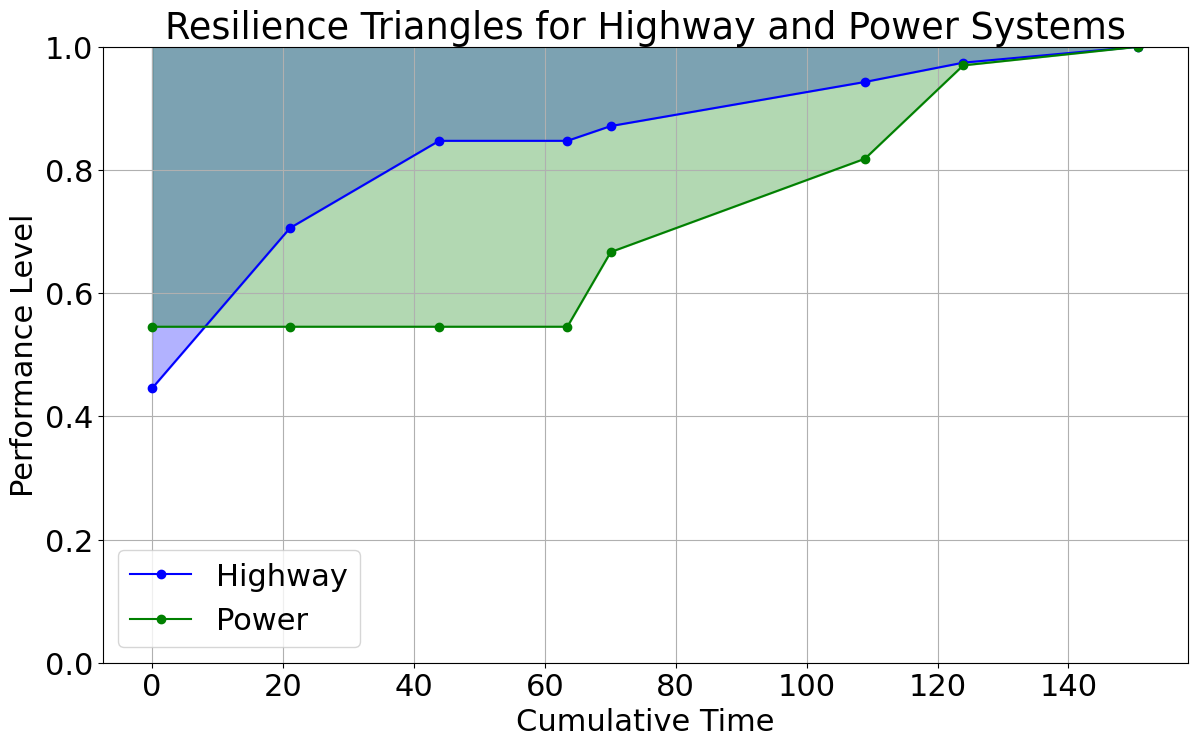

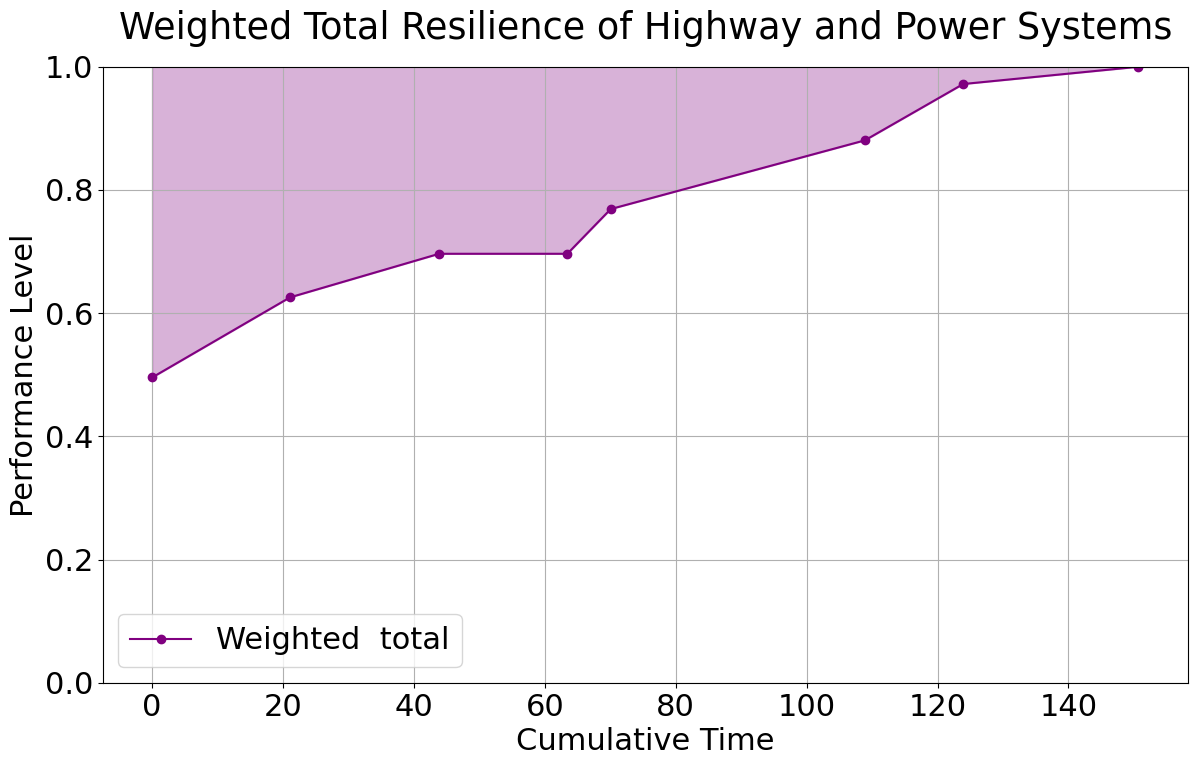

In [84]:
seq_SENS2_roadpri,roadres_SENS2_roadpri,powerres_SENS2_roadpri,time_SENS2_roadpri=run_model(roads_ans+power_ans,True,result_folder,"This is Road priority SENS2",'evalRoadPrioritySENS2',True)

eval


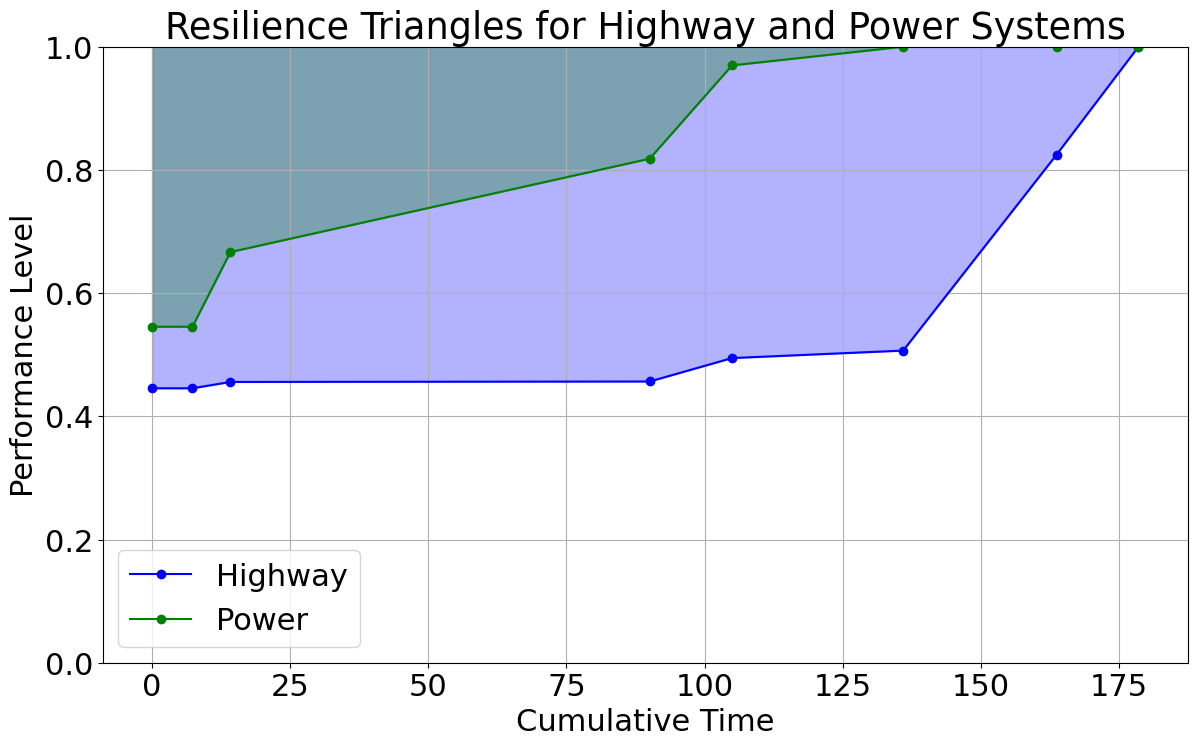

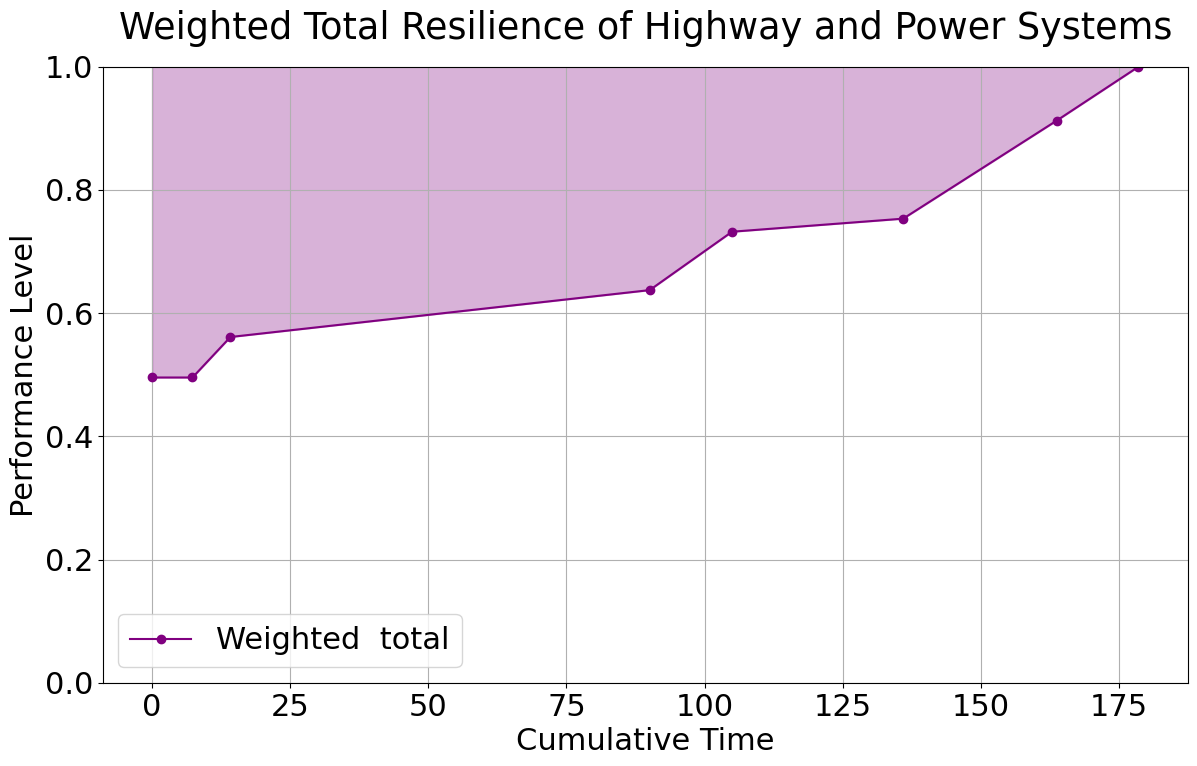

In [85]:
seq_SENS2_powerpri,roadres_SENS2_powerpri,powerres_SENS2_powerpri,time_SENS2_powerpri=run_model(power_ans+roads_ans,True,result_folder,"This is Power priority SENS2",'evalPowerPrioritySENS2',True)


Sensitivity #3
different harm level for broken net or power fail (interdependency level)

Initial population:
[(9, 10), 28, 11, 17, 15, 32, (11, 14)]
[28, 32, 11, (11, 14), 15, (9, 10), 17]
[28, 32, 15, 11, 17, (11, 14), (9, 10)]
[32, (11, 14), 11, 28, 15, (9, 10), 17]
[(9, 10), 11, 17, 32, 28, 15, (11, 14)]
gen	nevals	avg    	min                 	max                 
0  	100   	207.794	(93.75012077602838,)	(388.1658853102985,)
1  	53    	136.234	(82.87837292933688,)	(243.24259743784933,)
2  	63    	112.448	(75.90426292145128,)	(237.4352977778778,) 
3  	73    	107.485	(70.44710404992296,)	(246.37212249705607,)
4  	72    	99.3788	(70.44710404992296,)	(222.50873791772506,)
5  	61    	84.0309	(70.44710404992296,)	(219.23510903634713,)
6  	62    	81.3972	(70.44710404992296,)	(339.7141537116398,) 
7  	53    	79.2765	(70.44710404992296,)	(201.9620571444367,) 
8  	55    	84.9241	(70.44710404992296,)	(226.05600041383315,)
9  	52    	75.49  	(70.44710404992296,)	(226.05600041383315,)
10 	55    	78.7195	(70.44710404992296,)	(240.2953322705842,) 
11 	64    	83.1929	(70.44710404992296,

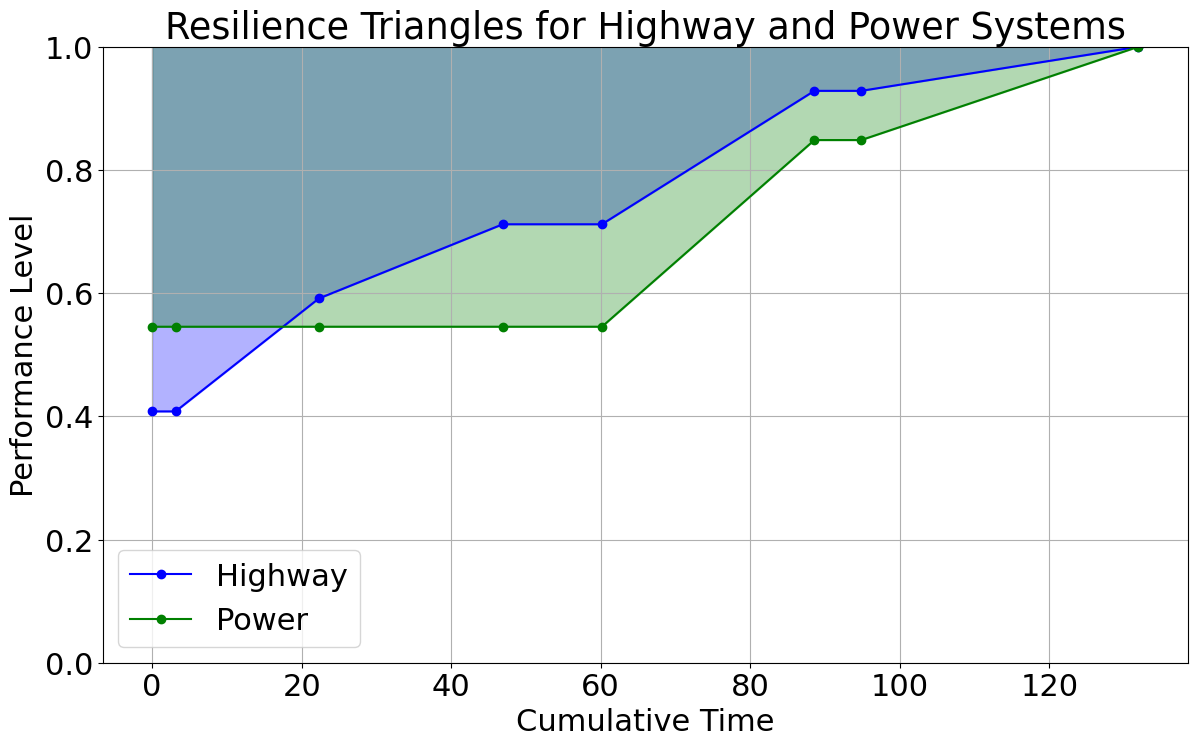

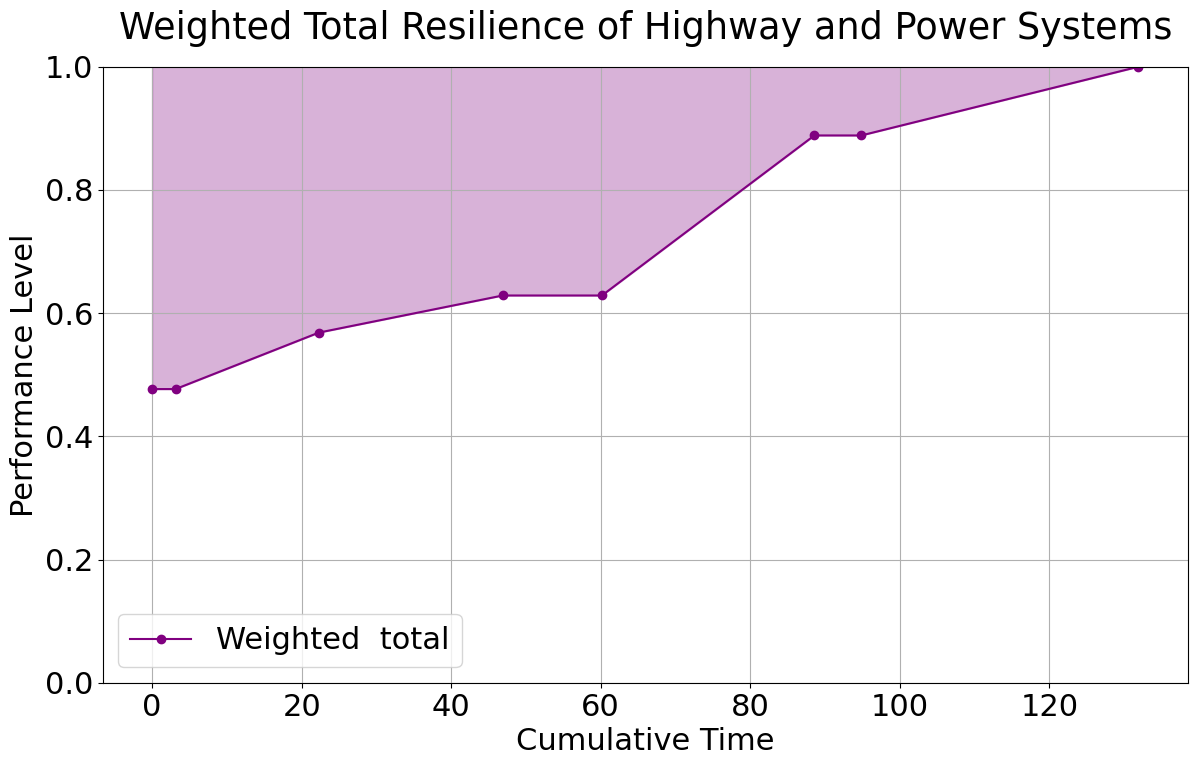

In [4]:
power_road_factor=0.3 #the lower of this the more severe the damage is
seq_SENS3_opt,roadres_SENS3_opt,powerres_SENS3_opt,time_SENS3_opt=run_model(sequence,True,result_folder,"This is SENSITIVITY #3, harm level increase",'SENS3',True)

In [5]:

powers_only=[11,17,15,28,32]
roads_only=[(9,10),(11,14)]
power_ans=run_model(powers_only,True,result_folder,"This is optimal Power only SENS3",'optPowerSENS3',False)[0]
roads_ans=run_model(roads_only,True,result_folder,"This is optimal Road only SENS3",'optRoadSENS3',False)[0]


Initial population:
[28, 32, 11, 17, 15]
[15, 28, 11, 17, 32]
[32, 11, 15, 17, 28]
[32, 28, 17, 11, 15]
[32, 15, 11, 28, 17]
gen	nevals	avg    	min                 	max                  
0  	100   	80.5767	(48.28460519164955,)	(140.77560992343288,)
1  	54    	59.3956	(48.28460519164955,)	(115.49333465791526,)
2  	51    	53.4016	(48.28460519164955,)	(94.49903863883387,) 
3  	56    	51.772 	(48.28460519164955,)	(94.82749074912113,) 
4  	66    	51.1118	(48.28460519164955,)	(135.47887045826795,)
5  	65    	50.3039	(48.28460519164955,)	(130.45914561188764,)
6  	56    	50.2008	(48.28460519164955,)	(98.38207474460037,) 
7  	58    	49.3327	(48.28460519164955,)	(68.40872511917806,) 
8  	56    	49.1877	(48.28460519164955,)	(70.32419723667093,) 
9  	61    	49.9565	(48.28460519164955,)	(82.01244608231299,) 
10 	56    	49.8029	(48.28460519164955,)	(94.49903863883387,) 
11 	48    	49.7791	(48.28460519164955,)	(93.07221108678485,) 
12 	66    	50.7114	(48.28460519164955,)	(94.82749074912113,) 
13 	53 

eval


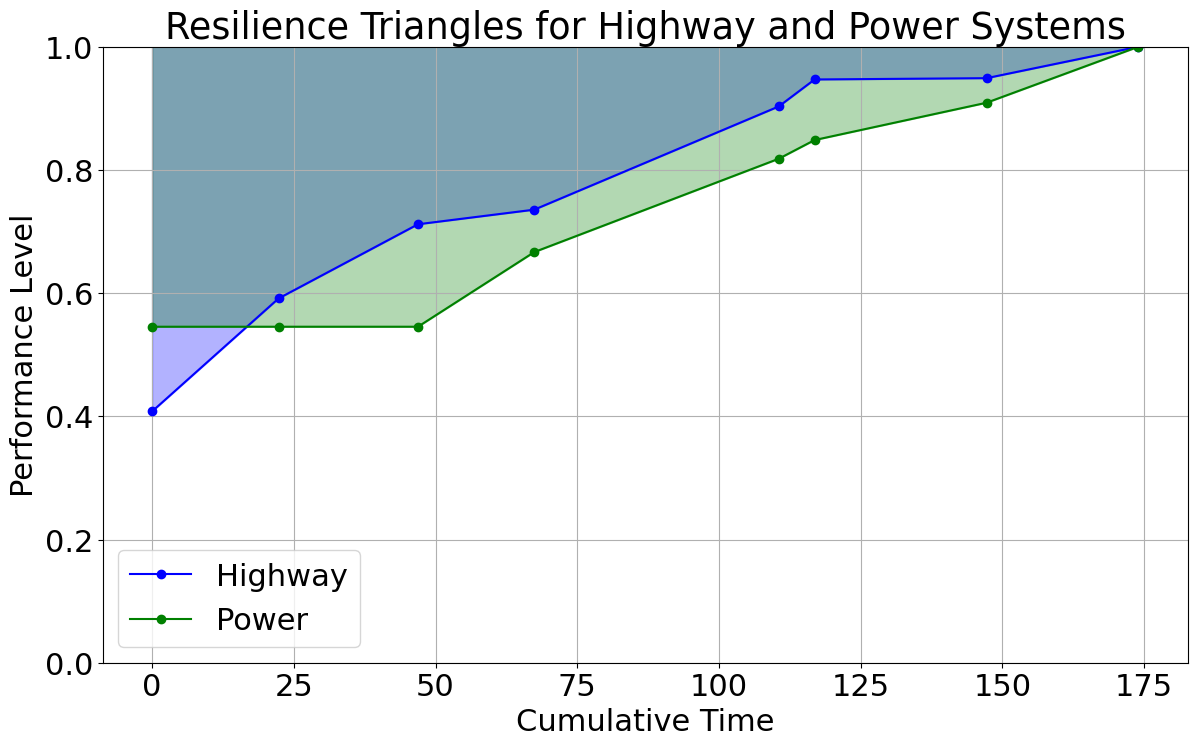

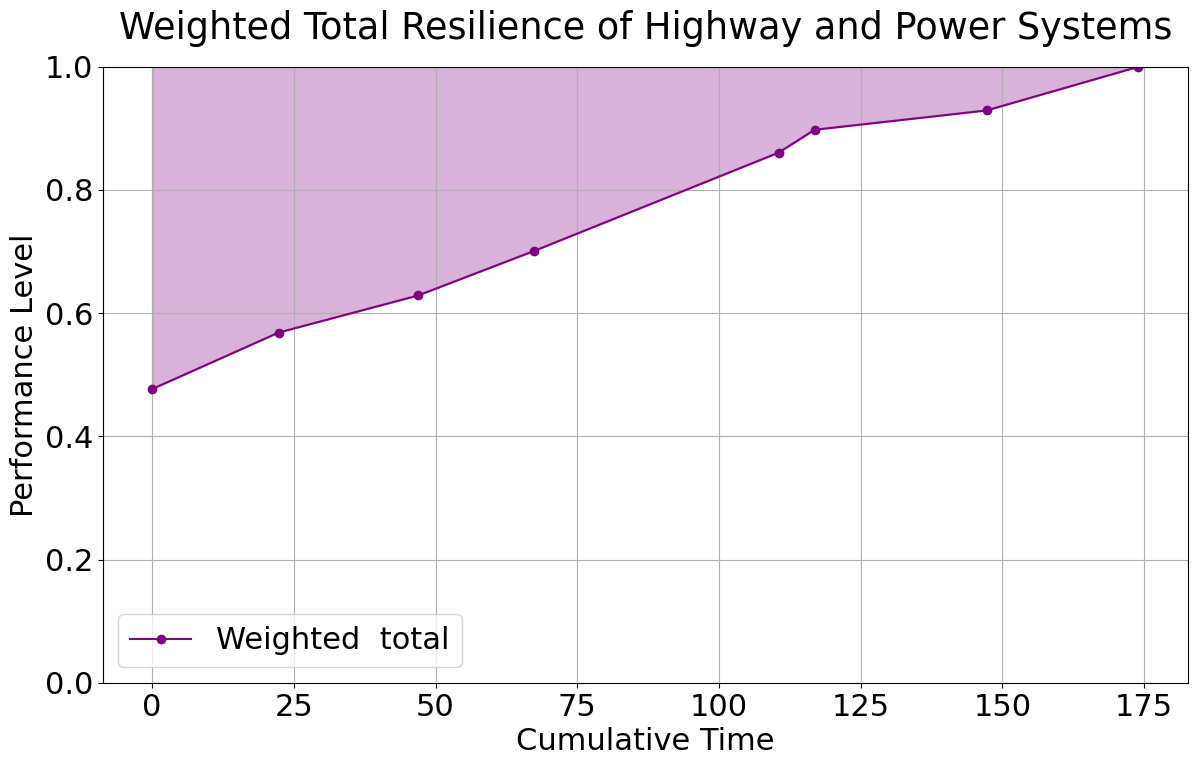

In [6]:
seq_SENS3_roadpri,roadres_SENS3_roadpri,powerres_SENS3_roadpri,time_SENS3_roadpri=run_model(roads_ans+power_ans,True,result_folder,"This is Road priority SENS3",'evalRoadPrioritySENS3',True)

eval


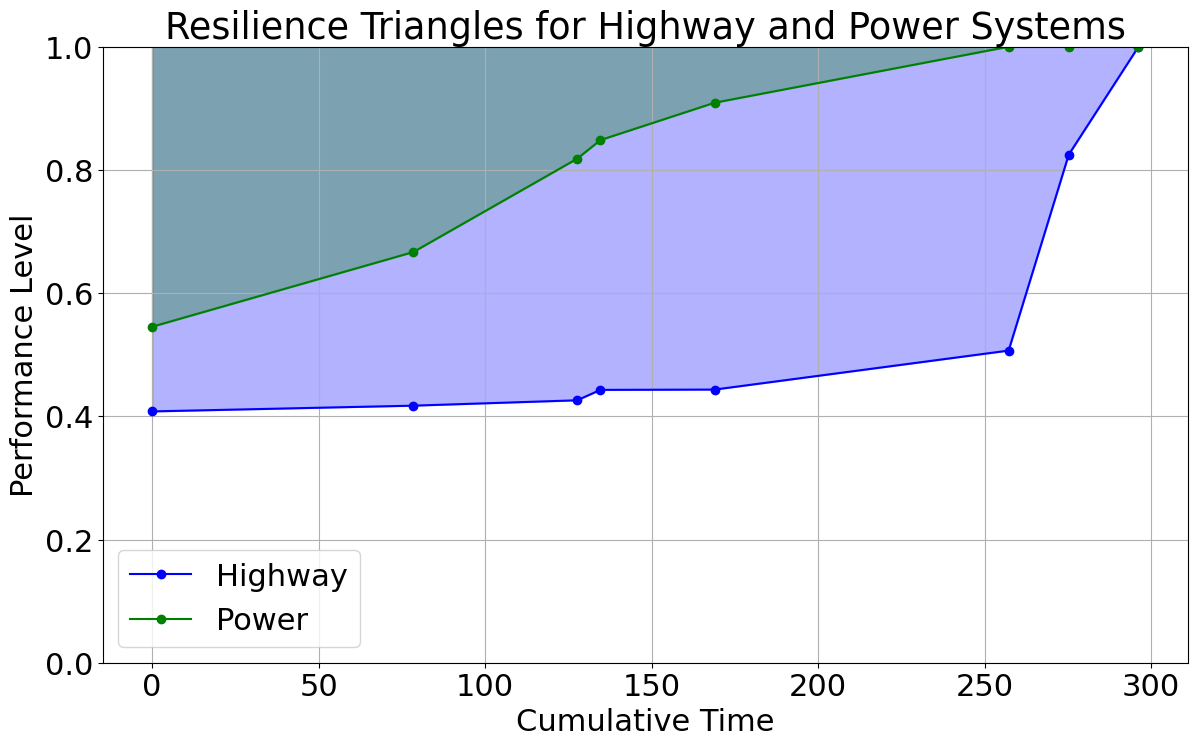

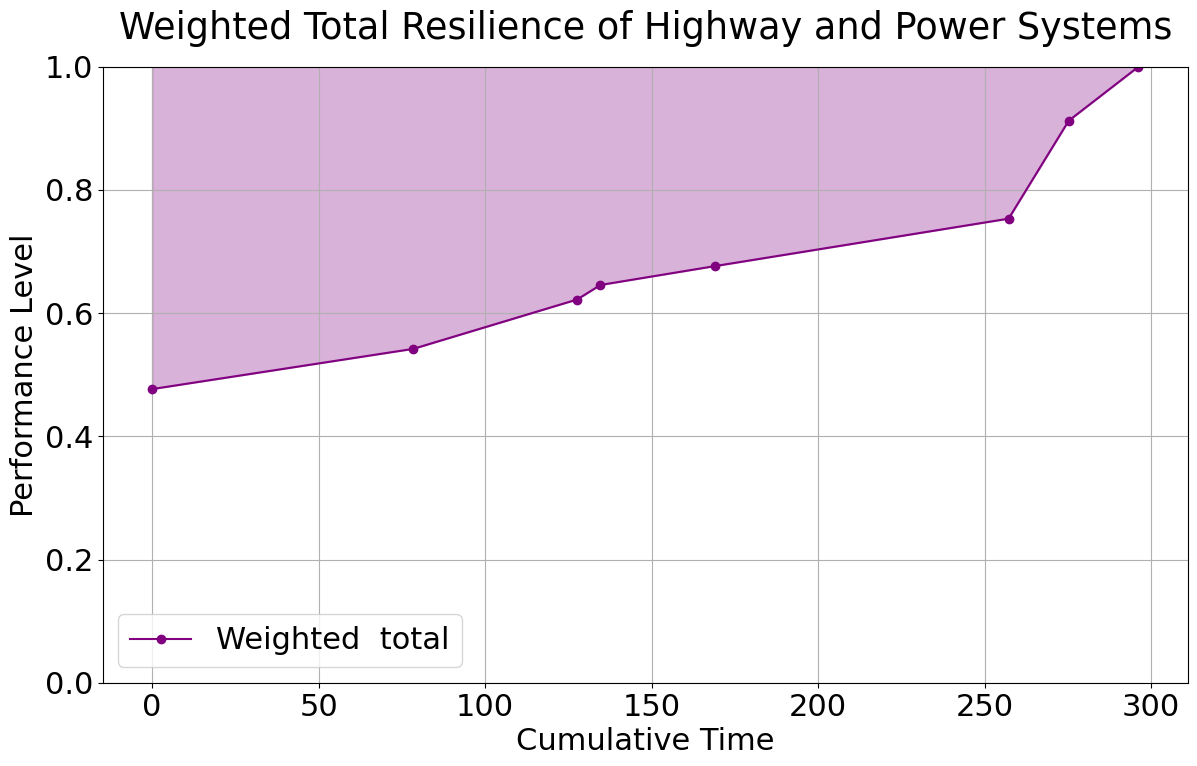

In [7]:
seq_SENS3_powerpri,roadres_SENS3_powerpri,powerres_SENS3_powerpri,time_SENS3_powerpri=run_model(power_ans+roads_ans,True,result_folder,"This is Power priority SENS3",'evalPowerPrioritySENS3',True)

In [8]:
power_road_factor=0.5

Sensitivity #4
Interdependency Pattern like where the interdependenct location is

Initial population:
[(9, 10), 15, 11, 17, (11, 14), 32, 28]
[32, 11, (9, 10), 28, (11, 14), 17, 15]
[17, 28, (9, 10), 15, (11, 14), 11, 32]
[17, 28, 15, (11, 14), 32, (9, 10), 11]
[15, (9, 10), (11, 14), 32, 17, 28, 11]
gen	nevals	avg    	min                 	max                 
0  	100   	215.369	(85.80720251436387,)	(434.7590837655122,)
1  	62    	135.617	(81.0317342249459,) 	(439.03652928666855,)
2  	59    	125.509	(81.0317342249459,) 	(391.91965206813063,)
3  	59    	102.965	(73.12959104942236,)	(270.84155267420596,)
4  	74    	102.5  	(73.12959104942236,)	(298.7398157917454,) 
5  	70    	110.821	(73.12959104942236,)	(298.7398157917454,) 
6  	65    	92.5411	(73.12959104942236,)	(298.7398157917454,) 
7  	57    	87.3436	(73.12959104942236,)	(262.379701210141,)  
8  	58    	81.4987	(73.12959104942236,)	(199.55120645007528,)
9  	61    	82.9261	(73.12959104942236,)	(315.46318319206716,)
10 	53    	82.4226	(73.12959104942236,)	(221.14288306165002,)
11 	54    	84.0475	(73.12959104942236,

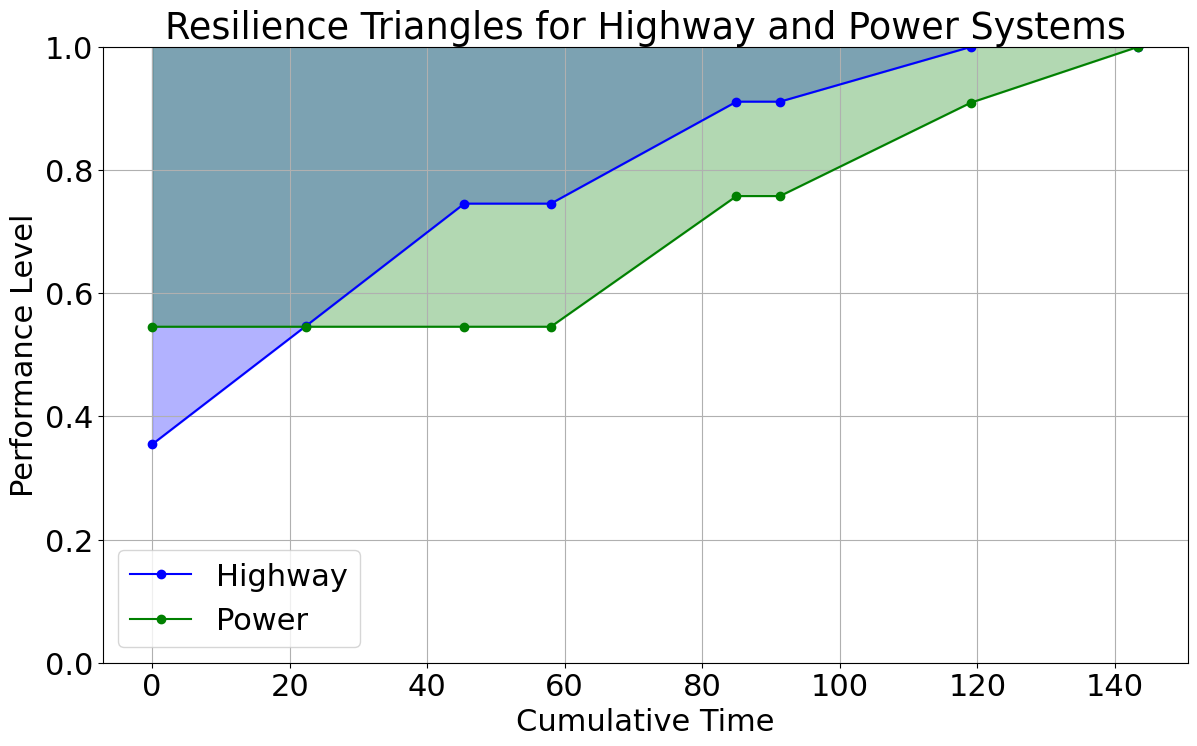

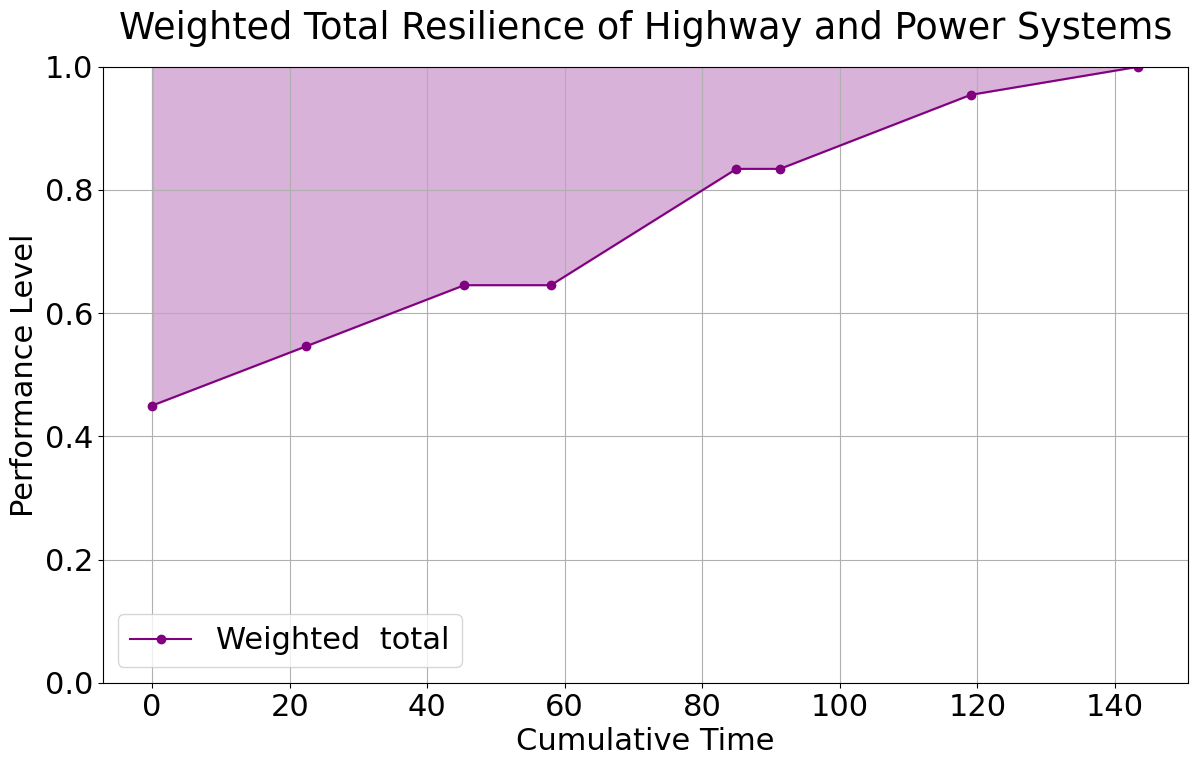

In [91]:
seq_SENS4_opt,roadres_SENS4_opt,powerres_SENS4_opt,time_SENS4_opt=run_model(sequence,True,result_folder,"This is SENSITIVITY #4, traffic light location",'SENS4',True)


In [92]:

powers_only=[11,17,15,28,32]
roads_only=[(9,10),(11,14)]
power_ans=run_model(powers_only,True,result_folder,"This is optimal Power only SENS4",'optPowerSENS4',False)[0]
roads_ans=run_model(roads_only,True,result_folder,"This is optimal Road only SENS4",'optRoadSENS4',False)[0]

Initial population:
[15, 17, 11, 28, 32]
[11, 17, 32, 15, 28]
[11, 32, 28, 15, 17]
[15, 28, 17, 11, 32]
[32, 28, 15, 11, 17]
gen	nevals	avg    	min                 	max                 
0  	100   	77.9114	(47.16550174746601,)	(149.5641401649315,)
1  	62    	55.3472	(47.16550174746601,)	(149.5641401649315,)
2  	54    	52.9403	(47.16550174746601,)	(135.40859691412902,)
3  	56    	49.6735	(47.16550174746601,)	(135.40859691412902,)
4  	55    	50.3873	(47.16550174746601,)	(112.03774554656721,)
5  	68    	50.3946	(47.16550174746601,)	(95.11832494708221,) 
6  	64    	50.763 	(47.16550174746601,)	(127.82136109675426,)
7  	55    	50.504 	(47.16550174746601,)	(135.40859691412902,)
8  	60    	50.6223	(47.16550174746601,)	(135.40859691412902,)
9  	59    	50.5666	(47.16550174746601,)	(100.63671782056437,)
10 	47    	48.9615	(47.16550174746601,)	(103.30545929392107,)
11 	54    	49.3667	(47.16550174746601,)	(95.11832494708221,) 
12 	46    	50.4136	(47.16550174746601,)	(95.11832494708221,) 
13 	52    

eval


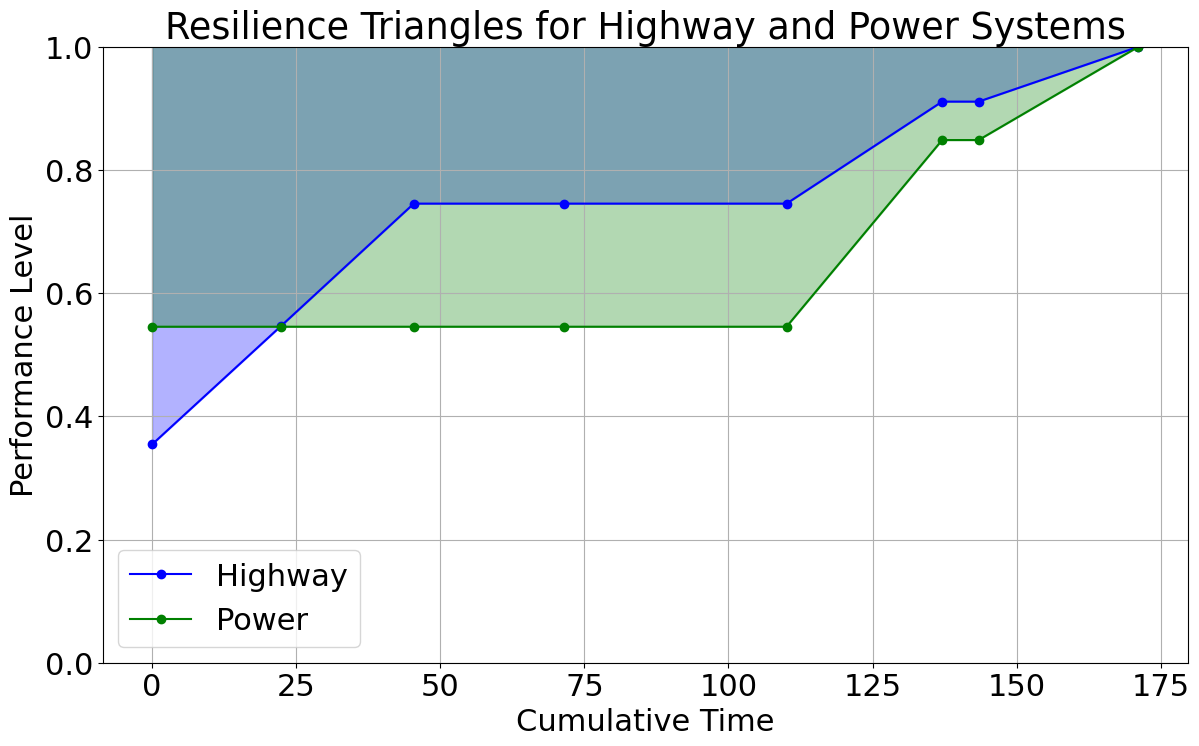

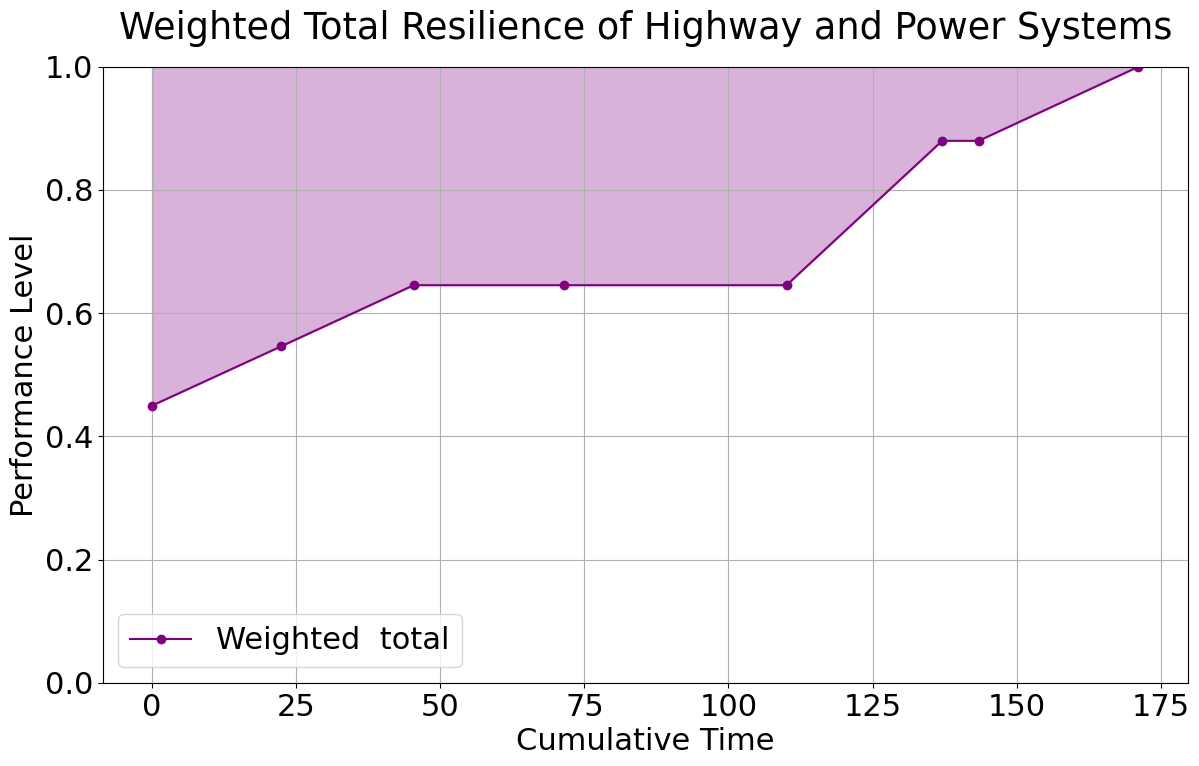

In [93]:
seq_SENS4_roadpri,roadres_SENS4_roadpri,powerres_SENS4_roadpri,time_SENS4_roadpri=run_model(roads_ans+power_ans,True,result_folder,"This is Road priority SENS4",'evalRoadPrioritySENS4',True)


eval


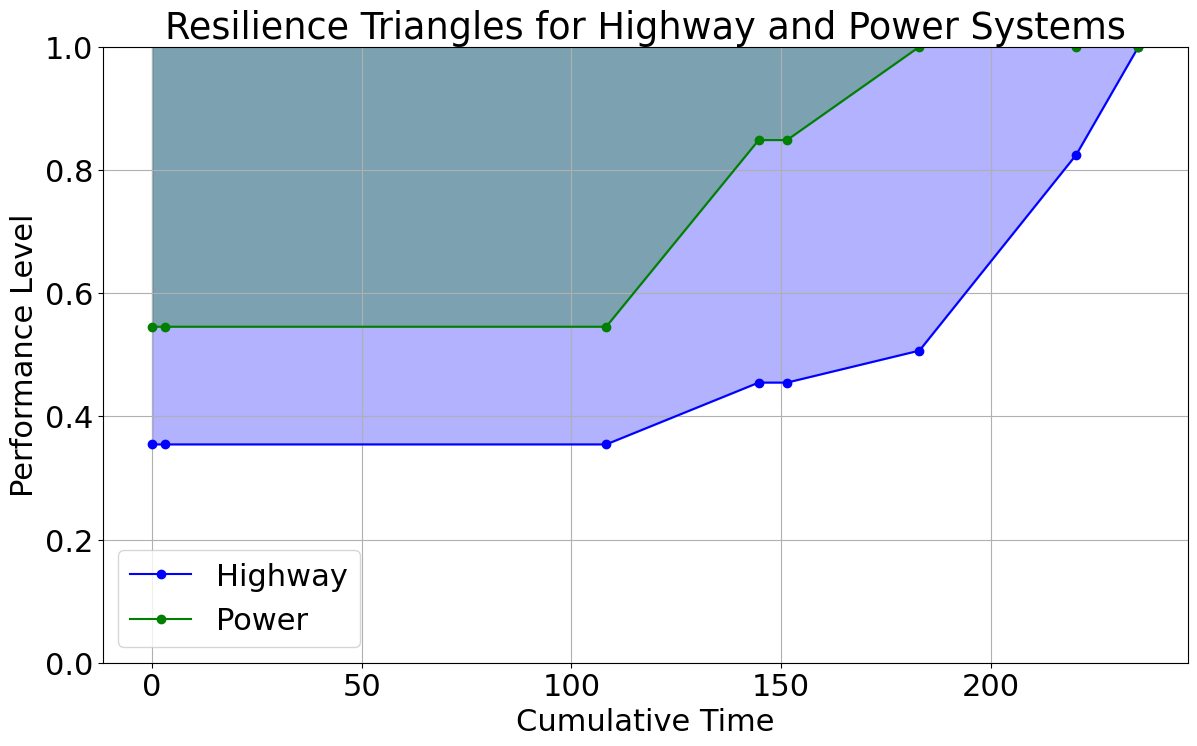

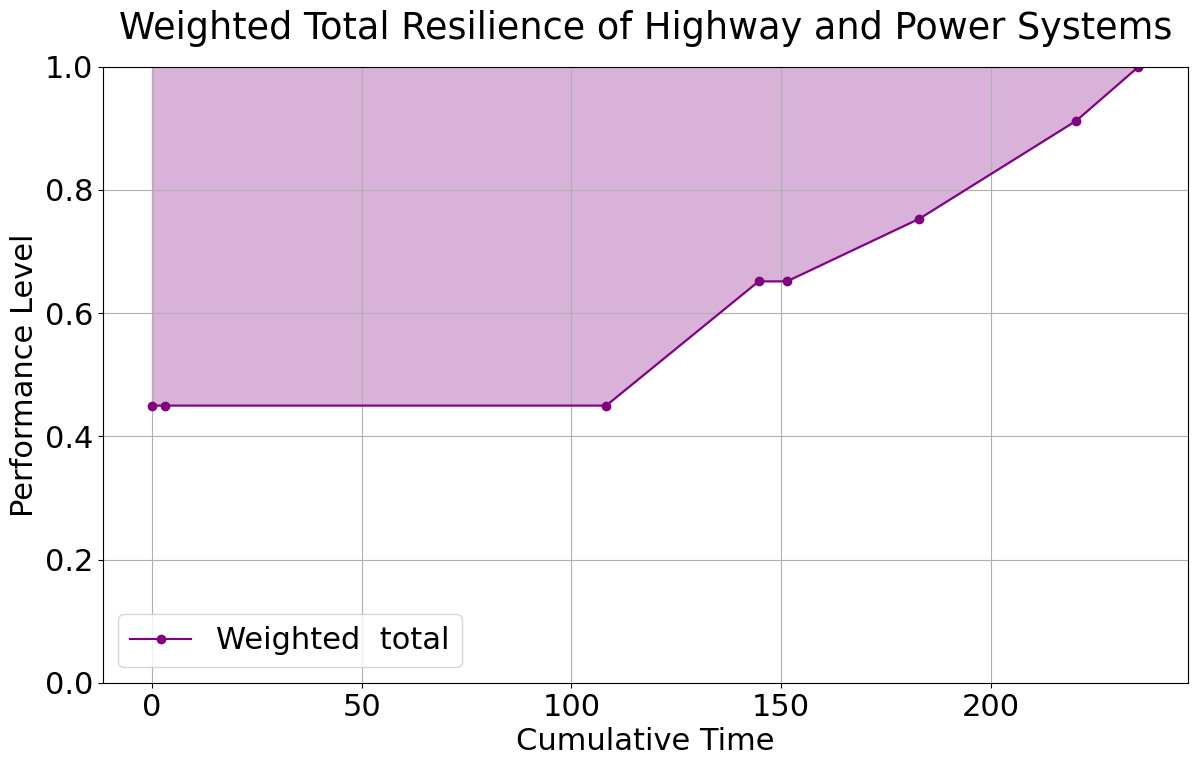

In [94]:
seq_SENS4_powerpri,roadres_SENS4_powerpri,powerres_SENS4_powerpri,time_SENS4_powerpri=run_model(power_ans+roads_ans,True,result_folder,"This is Power priority SENS4",'evalPowerPrioritySENS4',True)

Sensitivity #5
One directional interdependency

Initial population:
[(11, 14), 28, 17, 32, 15, 11, (9, 10)]
[28, 15, (9, 10), (11, 14), 32, 17, 11]
[15, 32, (9, 10), (11, 14), 17, 11, 28]
[32, (9, 10), (11, 14), 11, 28, 15, 17]
[15, 11, (9, 10), 32, 28, 17, (11, 14)]
gen	nevals	avg   	min                  	max                 
0  	100   	139.97	(48.016071913469375,)	(277.3454309706334,)
1  	59    	92.8108	(48.016071913469375,)	(236.64850615652705,)
2  	64    	69.653 	(47.270035821755805,)	(209.6722870761418,) 
3  	77    	67.7477	(47.270035821755805,)	(226.61695065169357,)
4  	67    	61.2477	(47.270035821755805,)	(176.9649706570558,) 
5  	63    	64.8588	(44.4676095862744,)  	(226.61695065169357,)
6  	59    	65.9569	(44.240429552368376,)	(226.61695065169357,)
7  	59    	59.6715	(44.4676095862744,)  	(193.76748636646548,)
8  	66    	57.2719	(44.240429552368376,)	(191.26666599620967,)
9  	49    	54.35  	(44.240429552368376,)	(173.04275111745278,)
10 	68    	56.5781	(44.240429552368376,)	(204.9109224411303,) 
11 	64    	53.1446	(44.24042

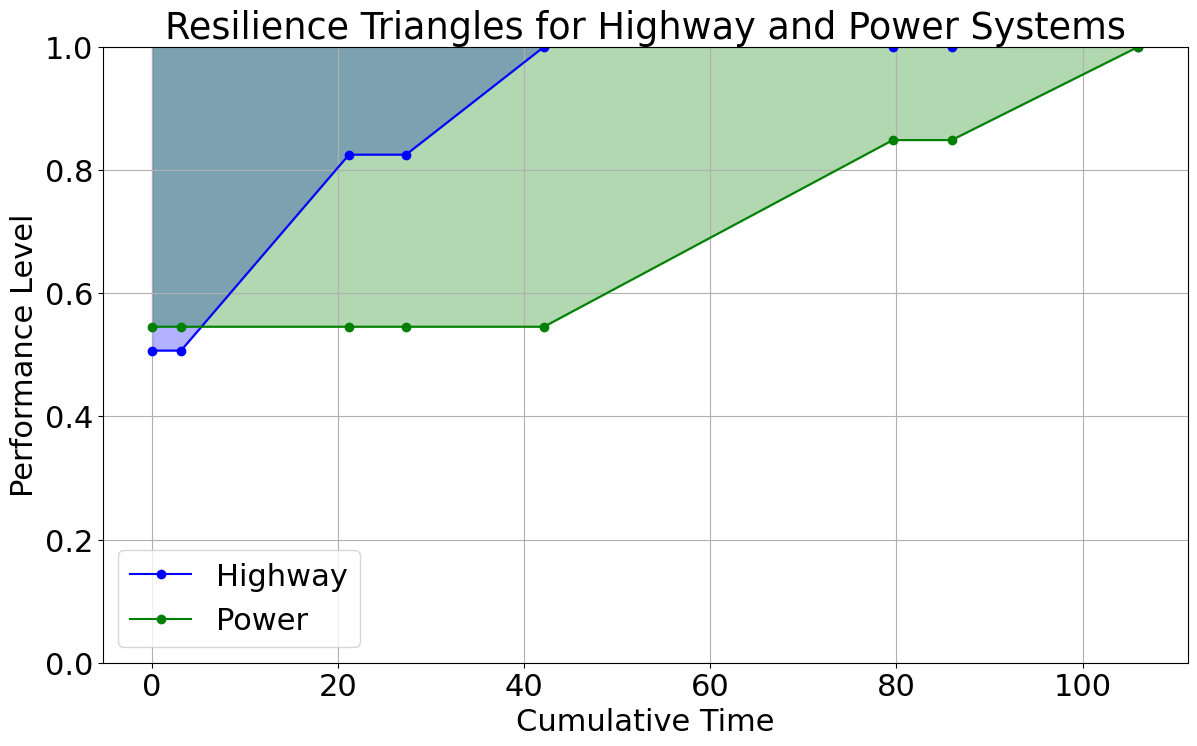

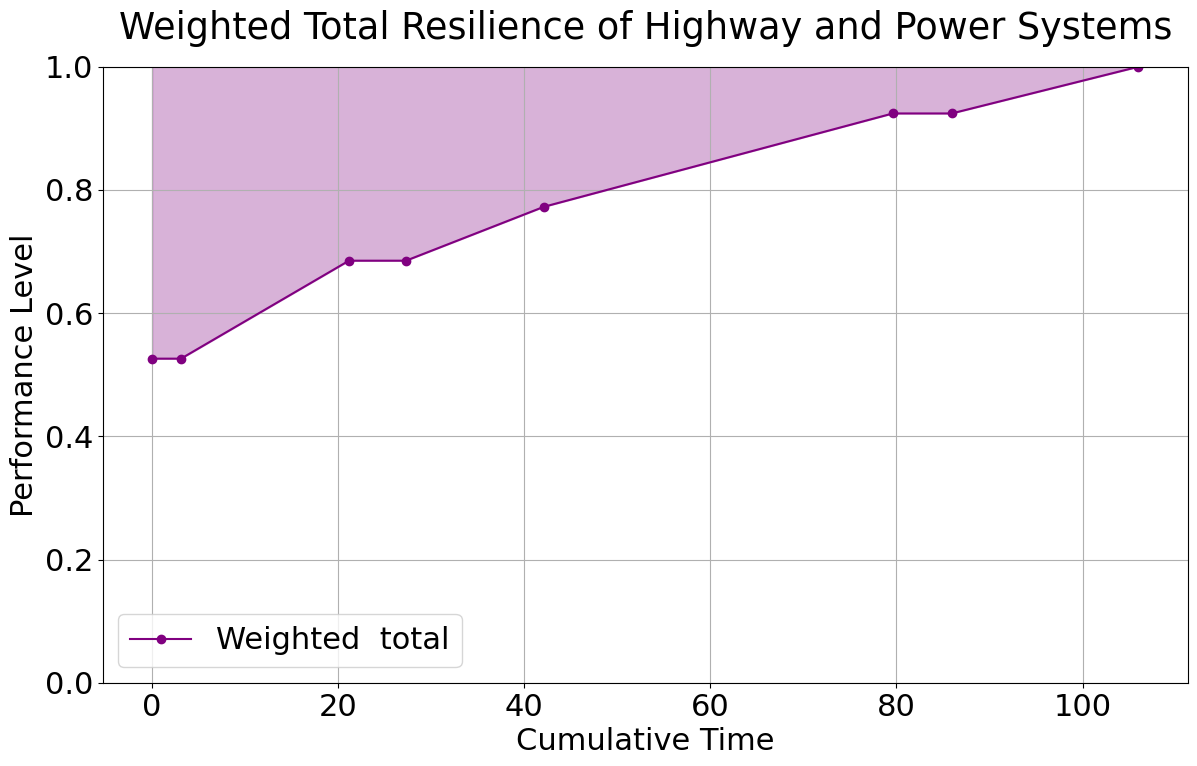

In [95]:
power_road_factor=1.0
seq_SENS5_opt,roadres_SENS5_opt,powerres_SENS5_opt,time_SENS5_opt=run_model(sequence,True,result_folder,"This is SENSITIVITY #5, one directional interdependency",'SENS5',True)

In [96]:

powers_only=[11,17,15,28,32]
roads_only=[(9,10),(11,14)]
power_ans=run_model(powers_only,True,result_folder,"This is optimal Power only SENS5",'optPowerSENS5',False)[0]
roads_ans=run_model(roads_only,True,result_folder,"This is optimal Road only SENS5",'optRoadSENS5',False)[0]


Initial population:
[15, 32, 17, 11, 28]
[15, 28, 17, 11, 32]
[28, 11, 17, 32, 15]
[11, 28, 32, 17, 15]
[15, 17, 11, 28, 32]
gen	nevals	avg    	min                 	max                 
0  	100   	39.6888	(20.48259596944059,)	(59.65426264763209,)
1  	58    	28.8669	(20.48259596944059,)	(59.43118931597982,)
2  	66    	24.6659	(20.48259596944059,)	(59.43118931597982,)
3  	60    	22.7837	(20.48259596944059,)	(54.99328505437155,)
4  	60    	22.1882	(20.48259596944059,)	(42.00005922661382,)
5  	68    	21.5291	(20.48259596944059,)	(38.81869861967068,)
6  	64    	21.7524	(20.48259596944059,)	(39.41741813706984,)
7  	59    	21.3483	(20.48259596944059,)	(43.71961098978949,)
8  	62    	22.2739	(20.48259596944059,)	(42.14274454295586,)
9  	67    	22.2847	(20.48259596944059,)	(59.43118931597982,)
10 	50    	22.4032	(20.48259596944059,)	(42.65923855657143,)
11 	66    	22.4181	(20.48259596944059,)	(43.71961098978949,)
12 	66    	21.4866	(20.48259596944059,)	(41.63093992378953,)
13 	54    	21.5002	(2

eval


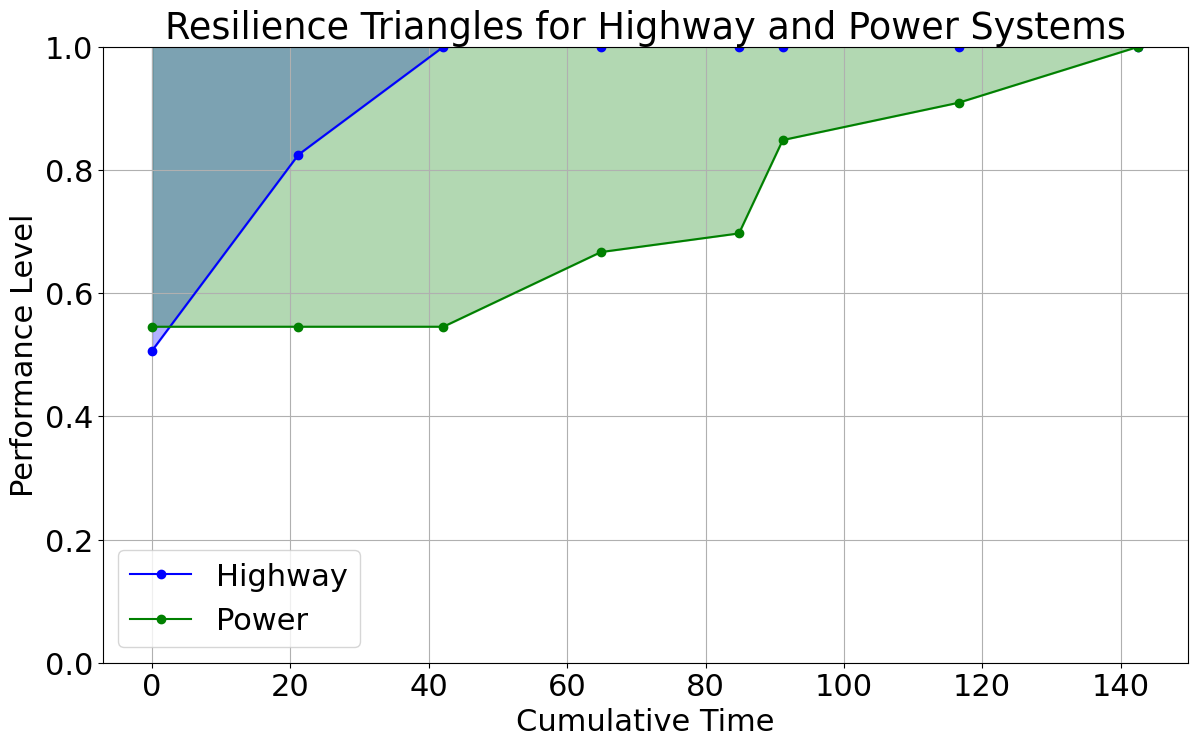

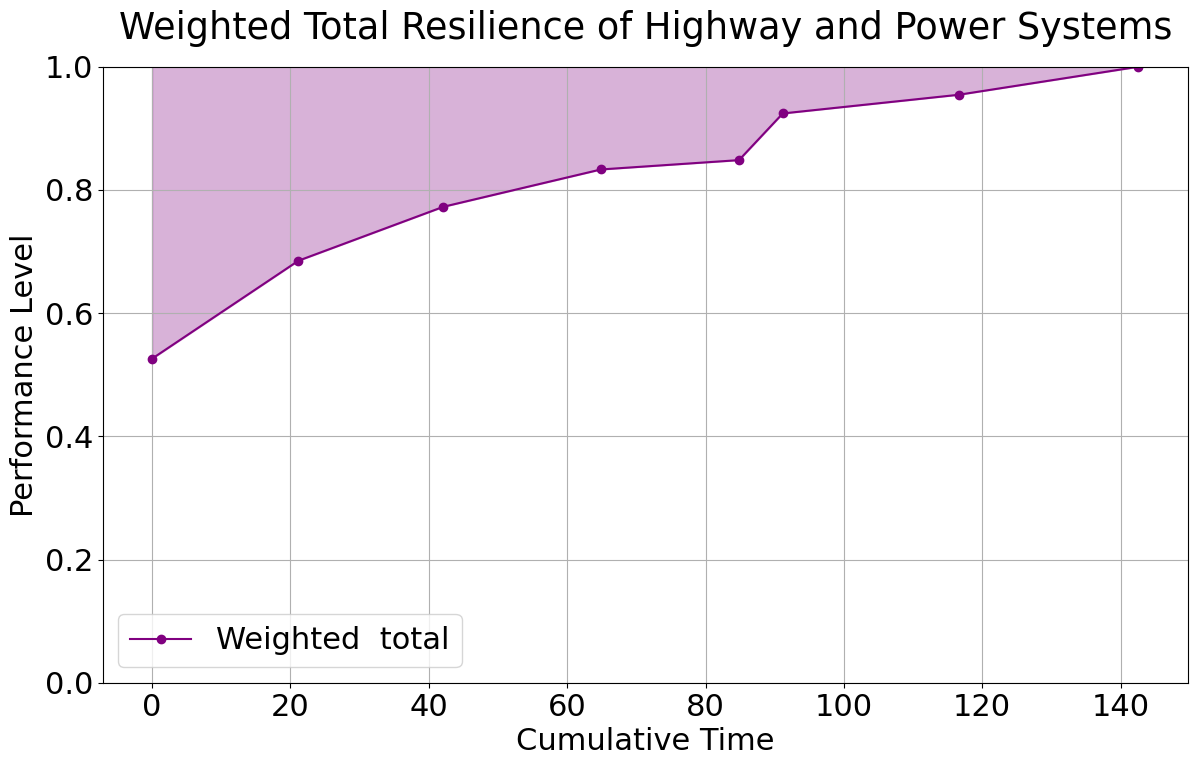

In [97]:
seq_SENS5_roadpri,roadres_SENS5_roadpri,powerres_SENS5_roadpri,time_SENS5_roadpri=run_model(roads_ans+power_ans,True,result_folder,"This is Road priority SENS5",'evalRoadPrioritySENS5',True)


eval


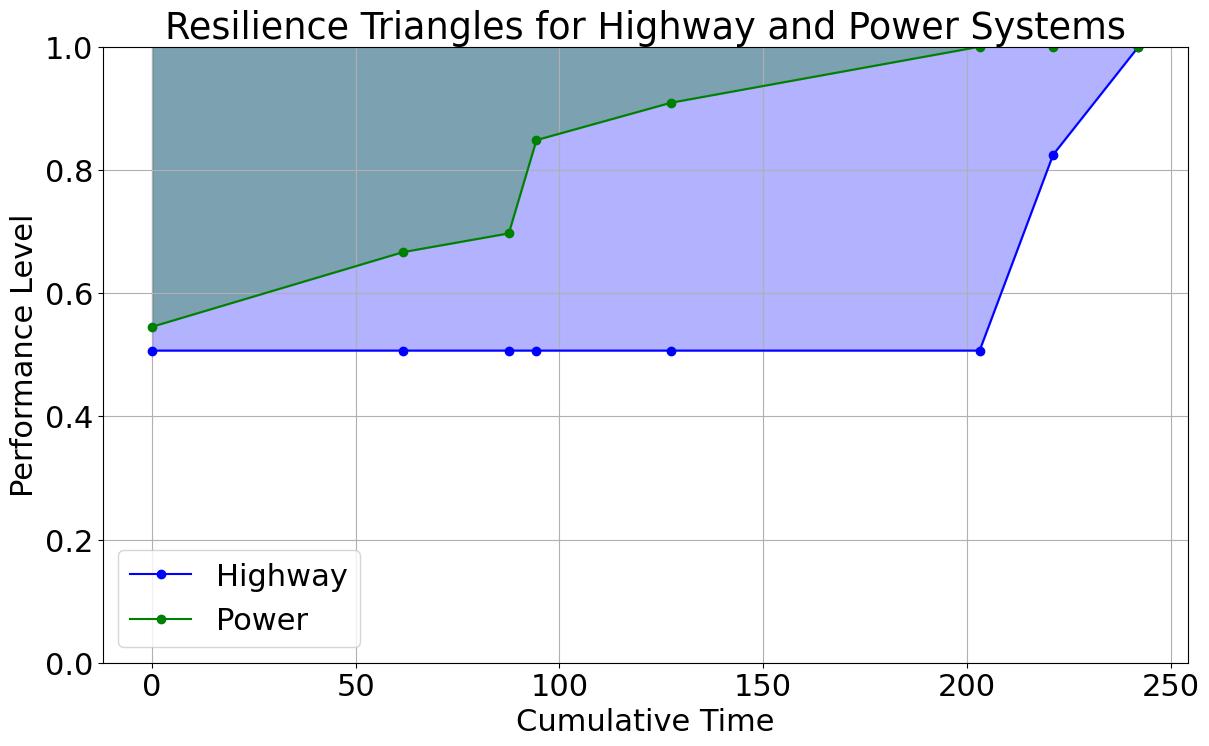

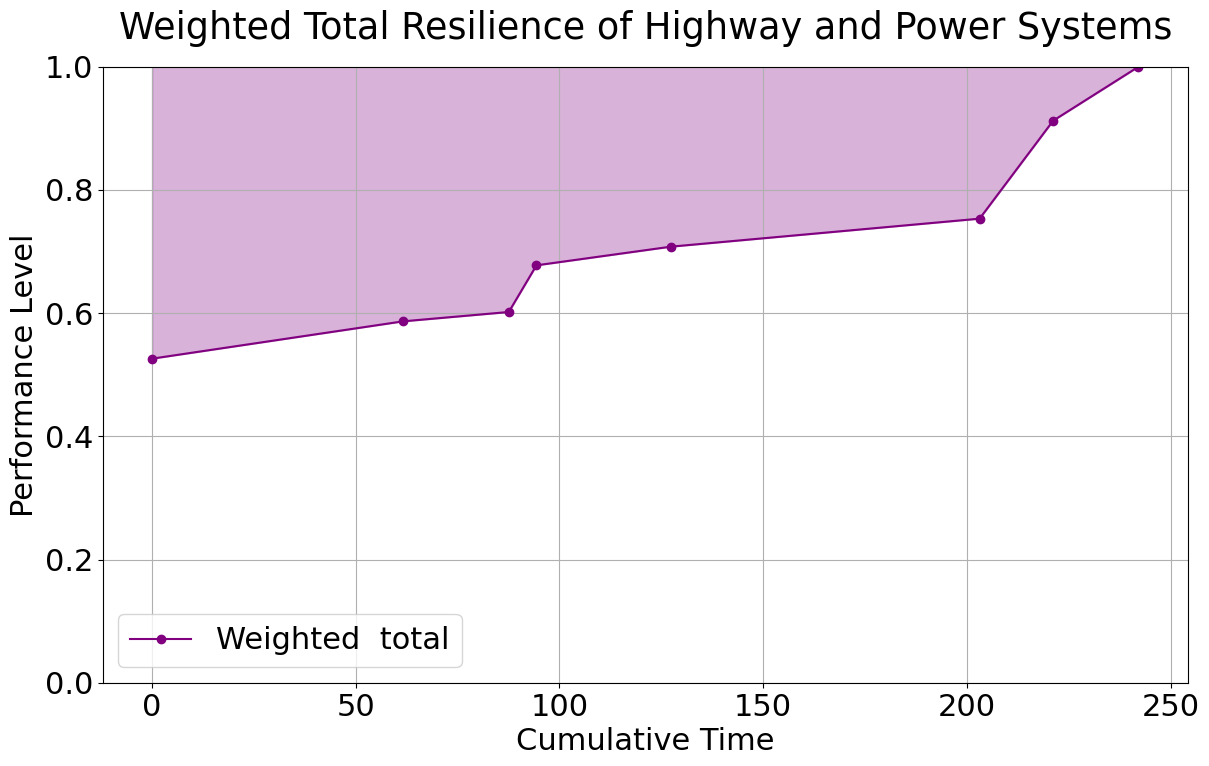

In [98]:
seq_SENS5_powerpri,roadres_SENS5_powerpri,powerres_SENS5_powerpri,time_SENS5_powerpri=run_model(power_ans+roads_ans,True,result_folder,"This is Power priority SENS5",'evalPowerPrioritySENS5',True)

Now This Generate some comparison sequence:
1. Compare default vs random
2. Compare default vs 2 priorities
3. SENS more broken compare with 2 priorities
4. SENS More severity vs 2 priorities
5. SENS default vs single dir   

Below are the hand made for QA purposes

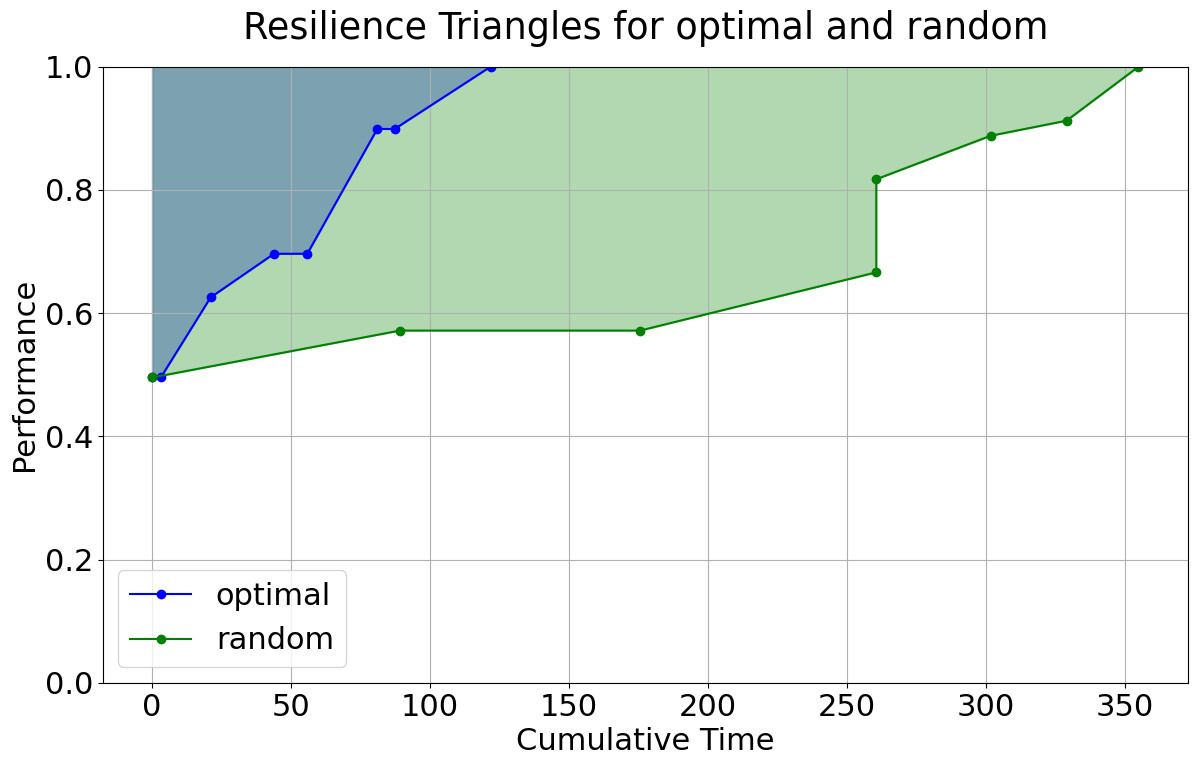

In [99]:
from plot_resilience import plot_triangles_compare2
default_seq=[17, (9, 10), (11, 14), 15, 11, 32, 28]
default_resilience_road=[0.44553396095539116, 0.44553396095539116, 0.7056831520794121, 0.847252092630669, 0.847252092630669, 0.949464697637762, 0.949464697637762]
default_resilience_power=[0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.8484848484848485, 0.8484848484848485]
default_resilience = [(a + b)/2 for a, b in zip(default_resilience_power, default_resilience_road)]
default_time=[3.133136, 17.931908, 22.778905, 11.996568, 25.178403, 6.258539, 34.487867]
random_seq=[11, 17, 15, (9, 10), 28, 32, (11, 14)]
random_resilience_road=[0.44553396095539116, 0.4464119913694029, 0.4464119913694029, 0.48397038317426355, 0.7862485062991831, 0.8060812859348895, 0.8247797898029301]
random_resilience_power=[0.5454545454545454, 0.696969696969697, 0.696969696969697, 0.8484848484848485, 0.8484848484848485, 0.9696969696969697, 1.0]
random_time=[89.172595, 86.403648, 84.97575900000001, 0, 41.120753, 27.328841000000004, 25.881401]
random_resilience = [(a + b)/2 for a, b in zip(random_resilience_power, random_resilience_road)]
plot_triangles_compare2(default_resilience, random_resilience,default_time,random_time,'optimal','random','compare_random_default')

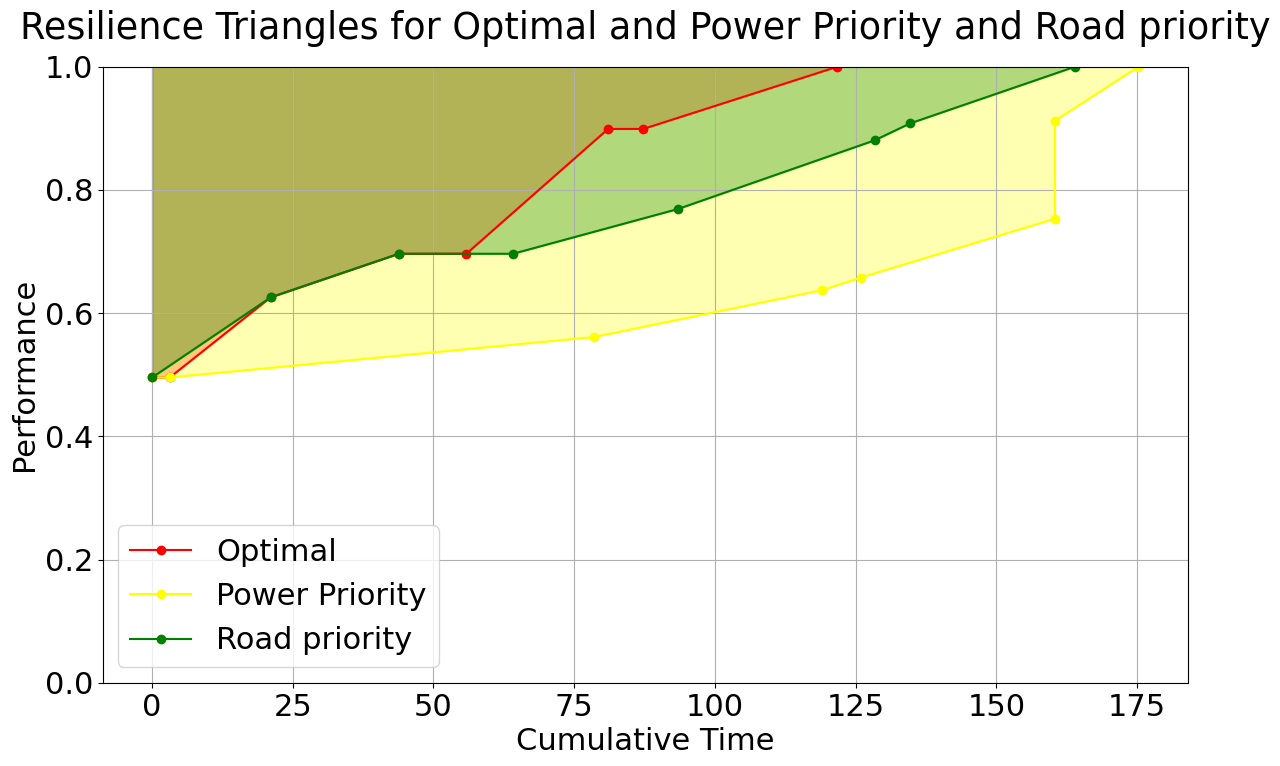

In [1]:
from plot_resilience import plot_triangles_compare3
default_seq=[17, (9, 10), (11, 14), 15, 11, 32, 28]
default_resilience_road=[0.44553396095539116, 0.44553396095539116, 0.7056831520794121, 0.847252092630669, 0.847252092630669, 0.949464697637762, 0.949464697637762]
default_resilience_power=[0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.8484848484848485, 0.8484848484848485]
default_resilience = [(a + b)/2 for a, b in zip(default_resilience_power, default_resilience_road)]
default_time=[3.133136, 17.931908, 22.778905, 11.996568, 25.178403, 6.258539, 34.487867]

Power_priority_seq=[17, 28, 11, 32, 15, (9, 10), (11, 14)]
Power_priority_road=[0.44553396095539116, 0.44553396095539116, 0.4558264932041891, 0.45653825632824463, 0.4670071116299994, 0.5067259434091717, 0.8247797898029301]
Power_priority_power=[0.5454545454545454, 0.5454545454545454, 0.6666666666666667, 0.8181818181818181, 0.8484848484848485, 1.0, 1.0]
Power_priority_time=[3.133136, 75.417666, 40.50453199999999, 6.902298, 34.483877, 0, 14.82433]
Power_priority_resilience = [(a + b)/2 for a, b in zip(Power_priority_power, Power_priority_road)]

Road_priority_seq=[(9, 10), (11, 14), 17, 28, 11, 32, 15]
Road_priority_road=[0.44553396095539116, 0.7056831520794121, 0.847252092630669, 0.847252092630669, 0.8712142852391935, 0.9428075561942305, 0.9676814075940526]
Road_priority_power=[0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.6666666666666667, 0.8181818181818181, 0.8484848484848485]
Road_priority_time=[21.065044, 22.778905, 20.296706, 29.270722, 34.977188, 6.320784, 29.284549]
Road_priority_resilience = [(a + b)/2 for a, b in zip(Road_priority_power, Road_priority_road)]

plot_triangles_compare3(default_resilience, Power_priority_resilience,Road_priority_resilience,default_time,Power_priority_time,Road_priority_time,'Optimal','Power Priority','Road priority','compare_deault_priority_default')

More links

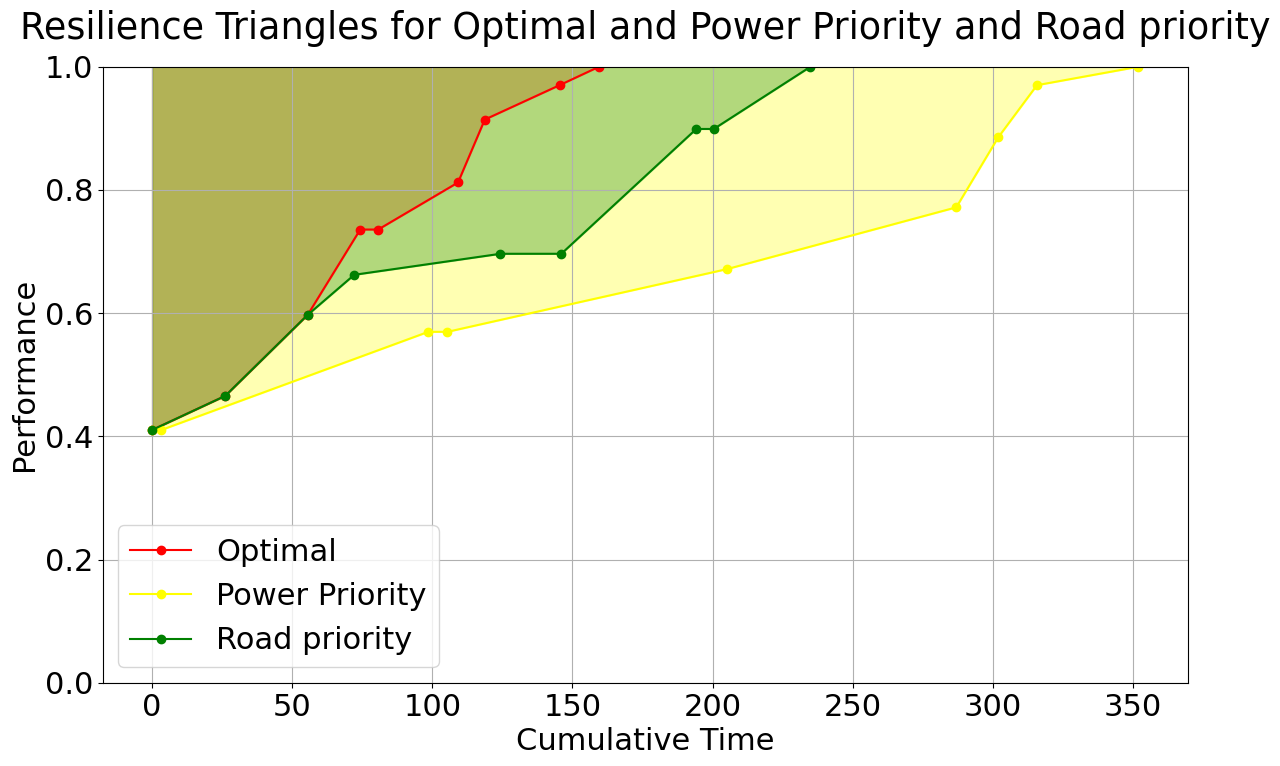

In [1]:
from plot_resilience import plot_triangles_compare3
default_seq=[(9, 10), (15, 22), 11, 32, (11, 14), 28, 17, (2, 6)]
default_resilience_road=[0.2751974005330034, 0.38591520708763666, 0.64893021416943, 0.7138279187378157, 0.7138279187378157, 0.8665601600799147, 0.9193135206296982, 0.9400822150101154]
default_resilience_power=[0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.7575757575757576, 0.7575757575757576, 0.7575757575757576, 0.9090909090909091, 1.0]
default_resilience = [(a + b)/2 for a, b in zip(default_resilience_power, default_resilience_road)]
default_time=[26.110763000000002, 29.405070000000002, 18.748646, 6.4153199999999995, 28.484389999999998, 9.545323, 26.694956, 14.068439000000001]

Power_priority_seq=[17, 11, 32, 28, (9, 10), (15, 22), (11, 14), (2, 6)]
Power_priority_road= [0.2751974005330034, 0.2751974005330034, 0.29084029029968783, 0.29084029029968783, 0.34299790015410614, 0.5435080699192547, 0.7709356539229091, 0.9400822150101154]
Power_priority_power=[0.5454545454545454, 0.5454545454545454, 0.8484848484848485, 0.8484848484848485, 1.0, 1.0, 1.0, 1.0]
Power_priority_time= [3.300229, 95.26665500000001, 6.8408169999999995, 99.756878, 81.795873, 14.979011, 13.810443, 36.221855000000005]
Power_priority_resilience = [(a + b)/2 for a, b in zip(Power_priority_power, Power_priority_road)]

Road_priority_seq=[(9, 10), (15, 22), (11, 14), (2, 6), 17, 11, 32, 28]
Road_priority_road=[0.2751974005330034, 0.38591520708763666, 0.64893021416943, 0.7789824728993422, 0.847252092630669, 0.847252092630669, 0.949464697637762, 0.949464697637762]
Road_priority_power= [0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.8484848484848485, 0.8484848484848485]
Road_priority_time=[26.110763000000002, 29.405070000000002, 16.613488, 52.192296999999996, 21.702342, 48.162824, 6.258539, 34.487867]
Road_priority_resilience = [(a + b)/2 for a, b in zip(Road_priority_power, Road_priority_road)]

plot_triangles_compare3(default_resilience, Power_priority_resilience,Road_priority_resilience,default_time,Power_priority_time,Road_priority_time,'Optimal','Power Priority','Road priority','compare_deault_priority_default')

change in point

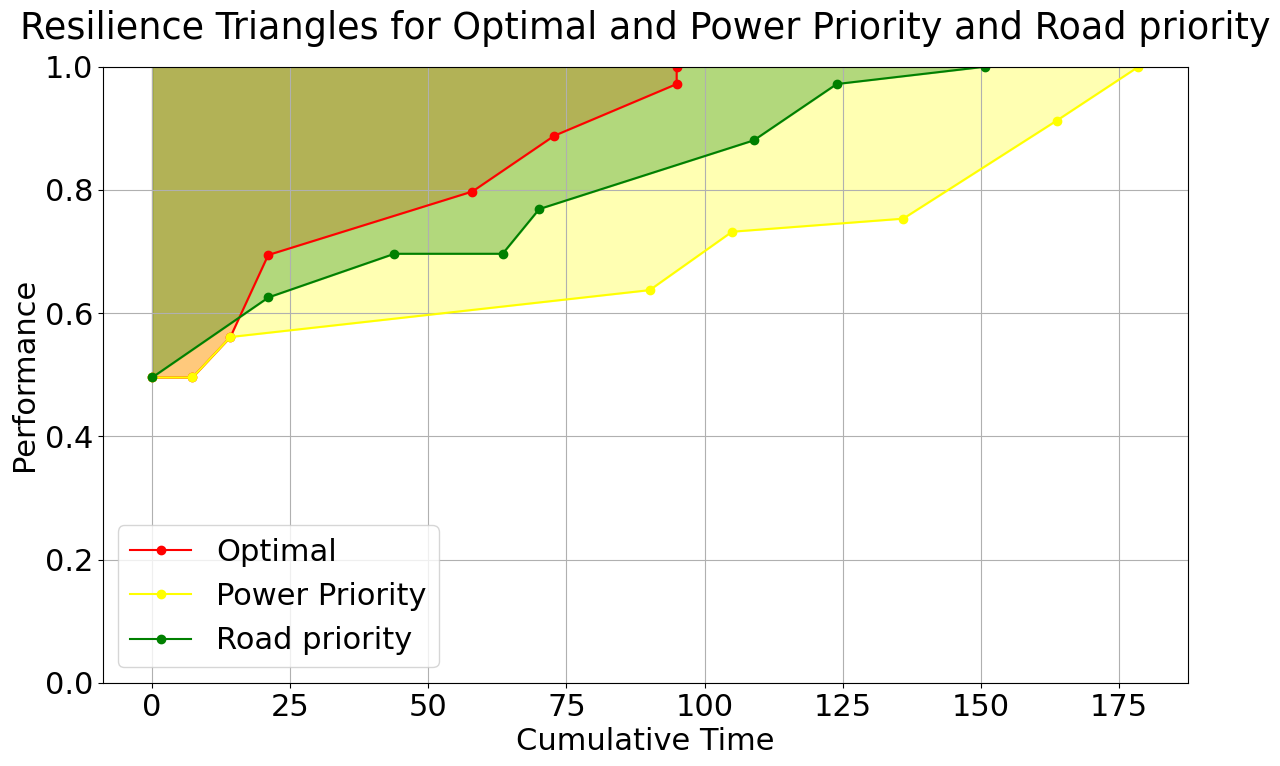

In [102]:
from plot_resilience import plot_triangles_compare3
default_seq=[17, 28, (9, 10), 11, 15, (11, 14), 32]
default_resilience_road=[0.44553396095539116, 0.44553396095539116, 0.4558264932041891, 0.7220365350641481, 0.7766566376163939, 0.8060812859348895, 0.9741351658932144]
default_resilience_power=[0.5454545454545454, 0.5454545454545454, 0.6666666666666667, 0.6666666666666667, 0.8181818181818181, 0.9696969696969697, 0.9696969696969697]
default_resilience = [(a + b)/2 for a, b in zip(default_resilience_power, default_resilience_road)]
default_time=[7.307385999999999, 6.865093, 6.840451, 36.947415, 14.811574, 22.166580999999997, 0]

Power_priority_seq=[17, 28, 11, 15, 32, (9, 10), (11, 14)]
Power_priority_road= [0.44553396095539116, 0.44553396095539116, 0.4558264932041891, 0.45653825632824463, 0.49459142794160155, 0.5067259434091717, 0.8247797898029301]
Power_priority_power=[0.5454545454545454, 0.5454545454545454, 0.6666666666666667, 0.8181818181818181, 0.9696969696969697, 1.0, 1.0]
Power_priority_time= [7.307385999999999, 6.865093, 75.884967, 14.903987, 30.978244000000004, 27.758454999999998, 14.82433]
Power_priority_resilience = [(a + b)/2 for a, b in zip(Power_priority_power, Power_priority_road)]

Road_priority_seq=[(9, 10), (11, 14), 17, 28, 11, 15, 32]
Road_priority_road=[0.44553396095539116, 0.7056831520794121, 0.847252092630669, 0.847252092630669, 0.8712142852391935, 0.9428075561942305, 0.9741351658932144]
Road_priority_power=[0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.6666666666666667, 0.8181818181818181, 0.9696969696969697]
Road_priority_time=[21.065044, 22.778905, 19.593203, 6.628176, 38.82838, 15.016524, 26.778851]
Road_priority_resilience = [(a + b)/2 for a, b in zip(Road_priority_power, Road_priority_road)]

plot_triangles_compare3(default_resilience, Power_priority_resilience,Road_priority_resilience,default_time,Power_priority_time,Road_priority_time,'Optimal','Power Priority','Road priority','compare_deault_priority_default')

move the connection around

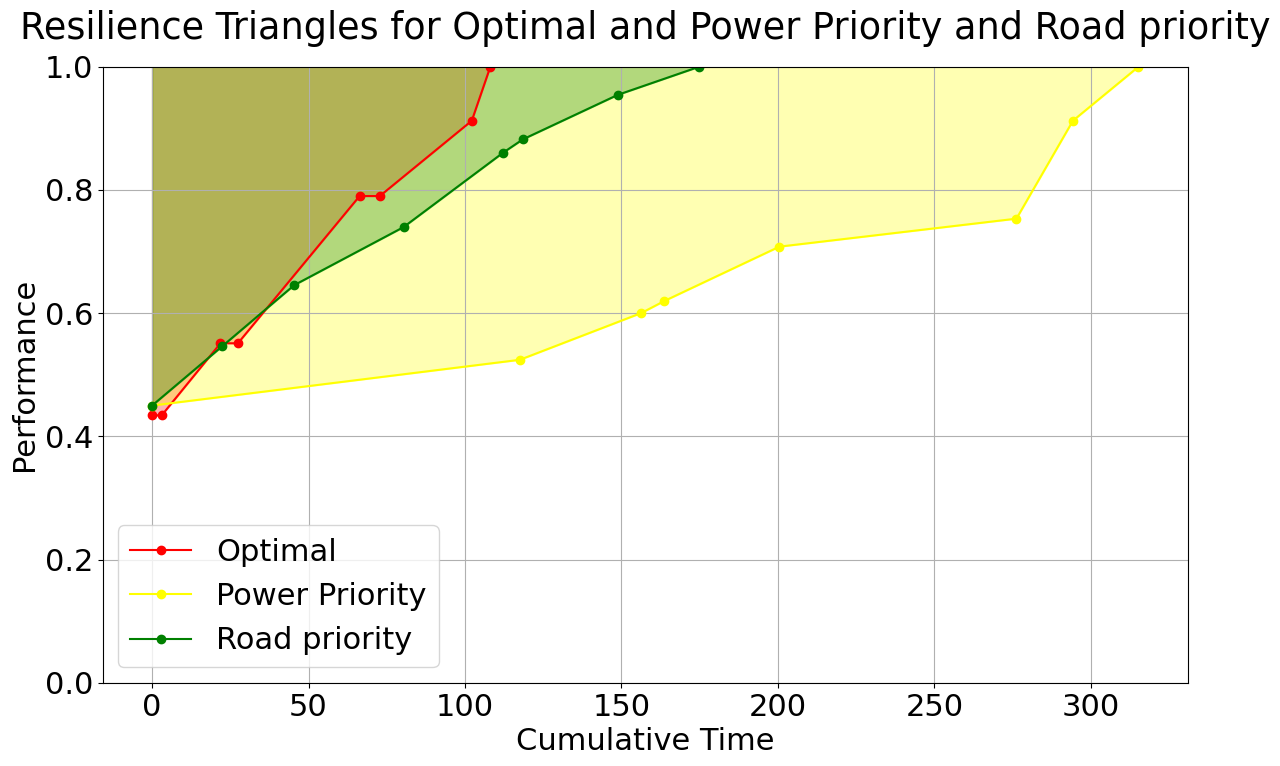

In [103]:
from plot_resilience import plot_triangles_compare3
default_seq=[17, (9, 10), 15, 11, 32, 28, (11, 14)]
default_resilience_road=[0.3226873635320036, 0.3226873635320036, 0.5566374056201964, 0.5566374056201964, 0.7316296448229149, 0.7316296448229149, 0.8247797898029301]
default_resilience_power=[0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.8484848484848485, 0.8484848484848485, 1.0]
default_resilience = [(a + b)/2 for a, b in zip(default_resilience_power, default_resilience_road)]
default_time=[3.066577, 18.773938, 5.582944, 38.893453, 6.449008, 29.409074, 5.92389]

Power_priority_seq=[28, 11, 32, 15, 17, (9, 10), (11, 14)]
Power_priority_road= [0.35443275794591855, 0.381780633474216, 0.3823966843777522, 0.39110068548704724, 0.506730244529252, 0.5067259434091717, 0.8247797898029301]
Power_priority_power= [0.5454545454545454, 0.6666666666666667, 0.8181818181818181, 0.8484848484848485, 0.9090909090909091, 1.0, 1.0]
Power_priority_time= [117.50583, 38.882221, 7.352157, 36.731321, 75.764278, 18.050473, 20.944219]
Power_priority_resilience = [(a + b)/2 for a, b in zip(Power_priority_power, Power_priority_road)]

Road_priority_seq=[(9, 10), (11, 14), 28, 11, 32, 15, 17]
Road_priority_road=[0.35443275794591855, 0.5467061056022448, 0.7453000944135837, 0.8125336560297621, 0.9024832629348606, 0.9155774927551052, 0.9996815326733492]
Road_priority_power=[0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.6666666666666667, 0.8181818181818181, 0.8484848484848485, 0.9090909090909091]
Road_priority_time=[22.37621, 23.019845, 34.953837, 31.790827999999998, 6.316212, 30.387303, 26.00071]
Road_priority_resilience = [(a + b)/2 for a, b in zip(Road_priority_power, Road_priority_road)]

plot_triangles_compare3(default_resilience, Power_priority_resilience,Road_priority_resilience,default_time,Power_priority_time,Road_priority_time,'Optimal','Power Priority','Road priority','compare_deault_priority_default')

More severity

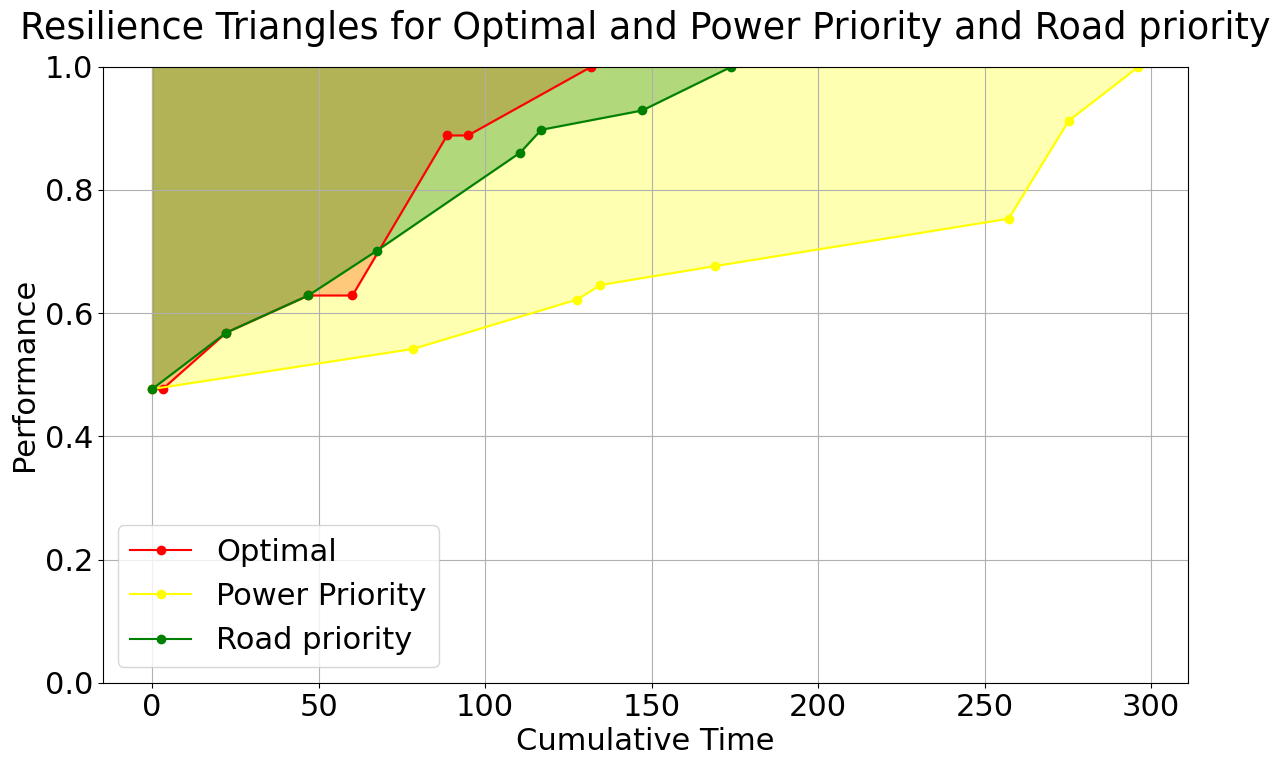

In [9]:
from plot_resilience import plot_triangles_compare3
default_seq=[17, (9, 10), (11, 14), 15, 11, 32, 28]
default_resilience_road=[0.40797797789421464, 0.40797797789421464, 0.5913013424621747, 0.7117890450408939, 0.7117890450408939, 0.9283791481184296, 0.9283791481184296]
default_resilience_power=[0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.8484848484848485, 0.8484848484848485]
default_resilience = [(a + b)/2 for a, b in zip(default_resilience_power, default_resilience_road)]
default_time=[3.13807, 19.160594000000003, 24.599747999999998, 13.266332, 28.415056000000003, 6.27192, 37.077369]

Power_priority_seq=[28, 11, 32, 15, 17, (9, 10), (11, 14)]
Power_priority_road=  [0.40797797789421464, 0.4173107978488609, 0.4260298686234501, 0.44293931137687736, 0.44342583975973715, 0.5067259434091717, 0.8247797898029301]
Power_priority_power=[0.5454545454545454, 0.6666666666666667, 0.8181818181818181, 0.8484848484848485, 0.9090909090909091, 1.0, 1.0]
Power_priority_time= [78.427083, 49.20872599999999, 7.012449, 34.270405999999994, 88.308151, 18.050473, 20.944219]
Power_priority_resilience = [(a + b)/2 for a, b in zip(Power_priority_power, Power_priority_road)]

Road_priority_seq=[(9, 10), (11, 14), 28, 11, 32, 15, 17]
Road_priority_road=[0.40797797789421464, 0.5913013424621747, 0.7117890450408939, 0.735507930227685, 0.903100606856624, 0.9468443263798874, 0.9489559992624957]
Road_priority_power=[0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.6666666666666667, 0.8181818181818181, 0.8484848484848485, 0.9090909090909091]
Road_priority_time=[22.298664000000002, 24.599747999999998, 20.517516999999998, 43.13199, 6.311872, 30.3358, 26.798399]
Road_priority_resilience = [(a + b)/2 for a, b in zip(Road_priority_power, Road_priority_road)]

plot_triangles_compare3(default_resilience, Power_priority_resilience,Road_priority_resilience,default_time,Power_priority_time,Road_priority_time,'Optimal','Power Priority','Road priority','compare_deault_priority_default')

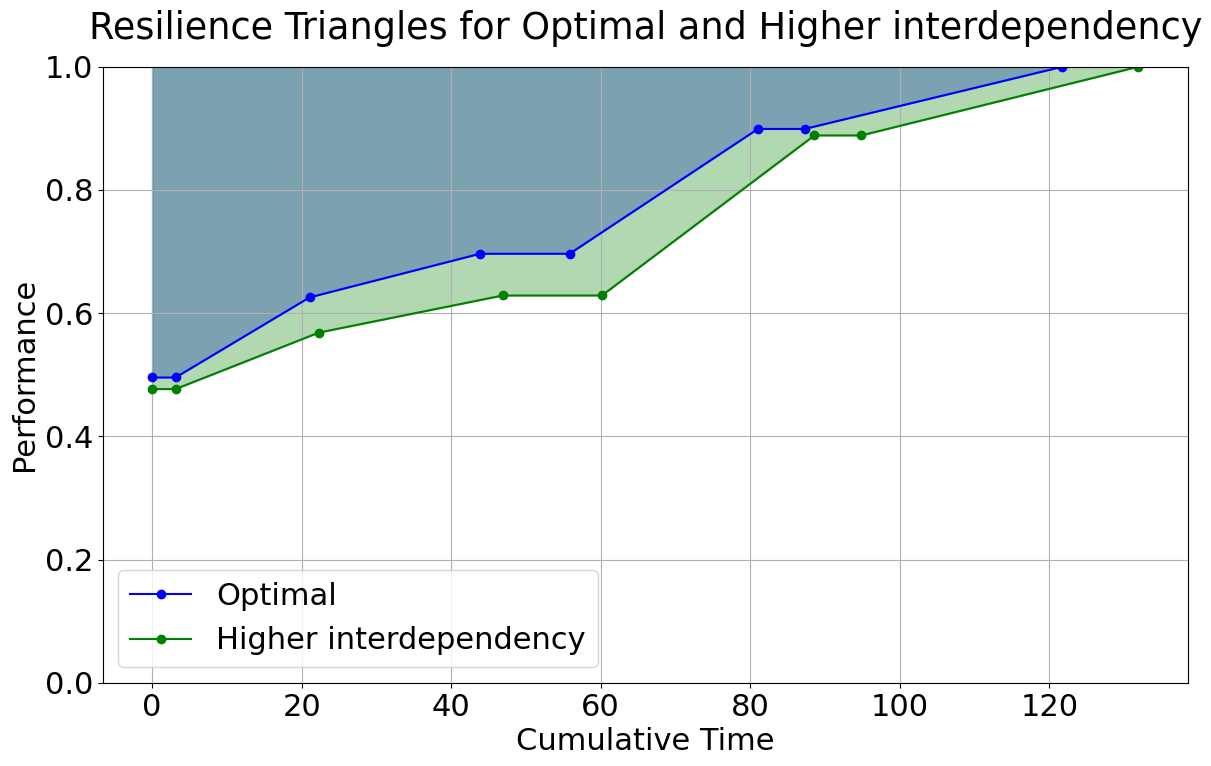

In [11]:
from plot_resilience import plot_triangles_compare2
default_seq=[17, (9, 10), (11, 14), 15, 11, 32, 28]
default_resilience_road=[0.44553396095539116, 0.44553396095539116, 0.7056831520794121, 0.847252092630669, 0.847252092630669, 0.949464697637762, 0.949464697637762]
default_resilience_power=[0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.8484848484848485, 0.8484848484848485]
default_resilience = [(a + b)/2 for a, b in zip(default_resilience_power, default_resilience_road)]
default_time=[3.133136, 17.931908, 22.778905, 11.996568, 25.178403, 6.258539, 34.487867]
SENS5_seq=[17, (9, 10), (11, 14), 15, 11, 32, 28]
SENS5_resilience_road=[0.40797797789421464, 0.40797797789421464, 0.5913013424621747, 0.7117890450408939, 0.7117890450408939, 0.9283791481184296, 0.9283791481184296]
SENS5_resilience_power=[0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.8484848484848485, 0.8484848484848485]
SENS5_time=[3.13807, 19.160594000000003, 24.599747999999998, 13.266332, 28.415056000000003, 6.27192, 37.077369]
SENS5_resilience = [(a + b)/2 for a, b in zip(SENS5_resilience_power, SENS5_resilience_road)]
plot_triangles_compare2(default_resilience, SENS5_resilience,default_time,SENS5_time,'Optimal','Higher interdependency','compare_higherinterd_default')

Put back sensitivity 5

In [105]:
power_road_factor=0.5
SENS5_result=[17, (9, 10), 15, (11, 14), 11, 32, 28]
run_model(SENS5_result,True,result_folder,"This is for sens5 on regular factor",'evalSENS5',False)

eval



([17, (9, 10), 15, (11, 14), 11, 32, 28],
 [0.44553396095539116,
  0.44553396095539116,
  0.7056831520794121,
  0.7056831520794121,
  0.847252092630669,
  0.949464697637762,
  0.949464697637762],
 [0.5454545454545454,
  0.5454545454545454,
  0.5454545454545454,
  0.5454545454545454,
  0.5454545454545454,
  0.8484848484848485,
  0.8484848484848485],
 [3.133136, 17.931908, 16.588904, 19.351115, 37.174971, 6.258539, 34.487867])

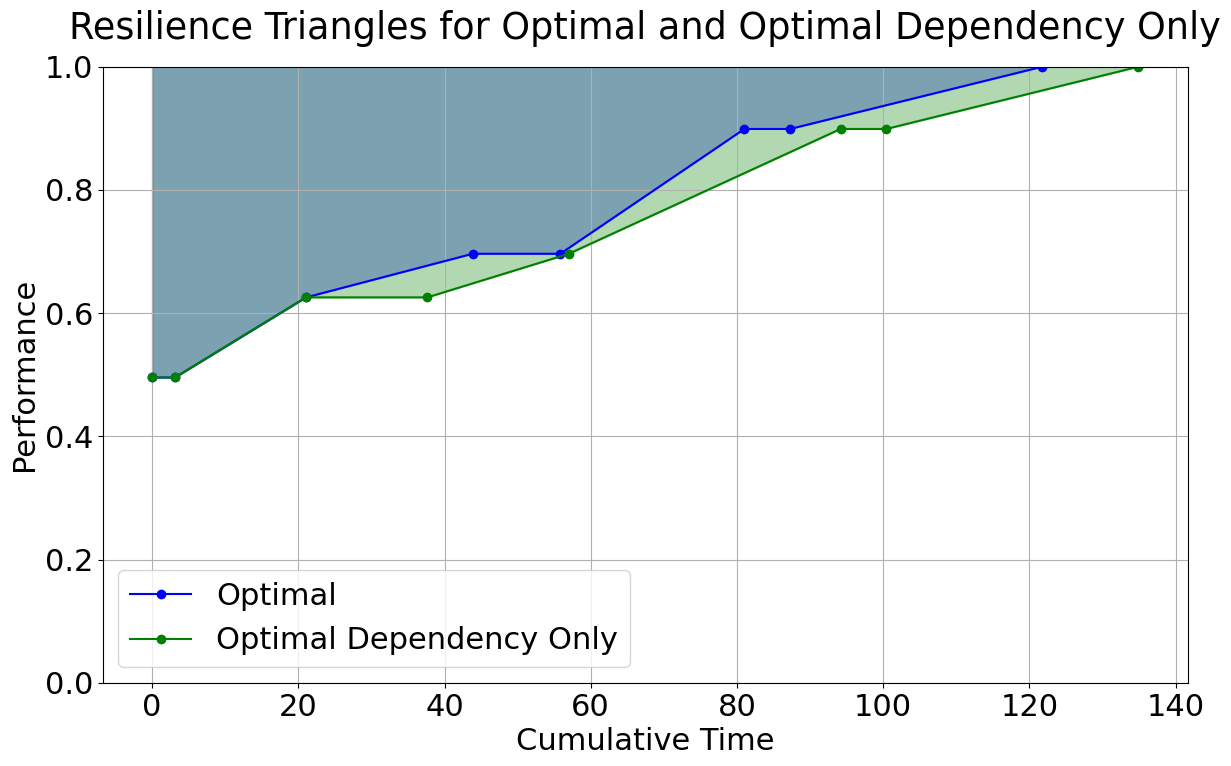

In [106]:
from plot_resilience import plot_triangles_compare2
default_seq=[17, (9, 10), (11, 14), 15, 11, 32, 28]
default_resilience_road=[0.44553396095539116, 0.44553396095539116, 0.7056831520794121, 0.847252092630669, 0.847252092630669, 0.949464697637762, 0.949464697637762]
default_resilience_power=[0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.8484848484848485, 0.8484848484848485]
default_resilience = [(a + b)/2 for a, b in zip(default_resilience_power, default_resilience_road)]
default_time=[3.133136, 17.931908, 22.778905, 11.996568, 25.178403, 6.258539, 34.487867]
SENS5_seq=[17, (9, 10), 15, (11, 14), 11, 32, 28]
SENS5_resilience_road=[0.44553396095539116, 0.44553396095539116, 0.7056831520794121, 0.7056831520794121, 0.847252092630669, 0.949464697637762, 0.949464697637762]
SENS5_resilience_power=[0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.8484848484848485, 0.8484848484848485]
SENS5_time=[3.133136, 17.931908, 16.588904, 19.351115, 37.174971, 6.258539, 34.487867]
SENS5_resilience = [(a + b)/2 for a, b in zip(SENS5_resilience_power, SENS5_resilience_road)]
plot_triangles_compare2(default_resilience, SENS5_resilience,default_time,SENS5_time,'Optimal','Optimal Dependency Only','compare_one-dir_default')

Sensitivity #X not used
Demand pattern, like 50% demand in at time 0 and gradual recover? hard to design
